# Code test

This jupyter notebook is for testing the functions for some analytical solvable cases.

## Libraries

In [1]:
# Library for linear algebra
import numpy as np
from numpy import linalg
from numpy import random
# Library and functions for the plots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.image import NonUniformImage
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
# Library for precompiled (and faster) code
import numba as numba
from numba import njit
# Library for optimization
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
# Library for error function
from scipy import special
# Library for curve fitting
from scipy.optimize import curve_fit

## 1 D test

In [2]:
@njit(fastmath=True)
def state(q): #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    state = 0  # Transition state
    if q > 1.0:
        # Product state
        state = 1
    if q < 0.0:
        # Reactant state
        state = -1
    return state

### Second test: linear potential

In [3]:
K = 0.01
@njit(fastmath=True)
def potential(q):
    return -K*q

@njit(fastmath=True)
def force(q):
    return K

In [4]:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
    # Define preliminary variables
    q = np.empty(isteps, dtype=np.float64)
    M = np.empty((isteps,2,2), dtype=np.float64)
    q[0] = -0.1
    i = 0
    j = 0
    tmp = 0
    s = state(q[0]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    zmax = 0.0
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        ## Evaluate evolution of the system
        f = force(q[i])
        # Linear combination of committors
        z0 = Guess1(q[i], KbT)
        z1 = Guess2(q[i], KbT)
        z = c[0]*z0+c[1]*z1
        # Gradient components of the committors
        dGx1 = dGuess1(q[i], KbT)
        dGx2 = dGuess2(q[i], KbT)
        # Matrix M
        M[i,0,0] = dGx1**2
        M[i,1,0] = dGx2*dGx1
        M[i,0,1] = dGx1*dGx2
        M[i,1,1] = dGx2**2
        #print(z0, z1, z[i])
        if z > zmax:
            q[i+1] = q[i]+f*dt+D*np.random.normal(0,1)
            zmax = z
        else:
            q[i+1] = q[i]+f*dt+D*np.random.normal(0,1)+kr*(c[0]*dGx1 + c[1]*dGx2)*(zmax - z)*dt
        i += 1
        s = state(q[i])
        
    M *= np.sqrt(2.0*KbT)  # This line technically is not needed because later we rescale everything. Kept for consistency
    
    # Output in the case we do not find a reactive coordinate, so that the function does not crash
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty(1, dtype=np.float64)
        out[0] = 0.0
        outM = np.empty((1, 2, 2), dtype=np.float64)
        outM[0,0,0] = 0.0
        outM[0,1,0] = 0.0
        outM[0,0,1] = 0.0
        outM[0,1,1] = 0.0
        return out, outM
        
    return q[j+1:i-1], M[j+1:i-1,:,:]

In [5]:
def Boltz_sample(Guess1, dGuess1, Guess2, dGuess2, c = [0.5, 0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000, jsteps = 1000):
    # Sampling of transition region
    tmp = 0
    for j in range(jsteps):
        traj, M = LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = c, dt = dt, KbT = KbT, kr = kr, isteps= isteps)
        if traj[0] != 0:
            if tmp==0:
                trajall = np.copy(traj)
                Mall = np.copy(M)
                tmp = 1
            if tmp==1:
                trajall = np.concatenate((trajall, traj), axis=0)
                Mall = np.concatenate((Mall, M), axis=0)
        del traj, M
    
    # Evaluation of M
    M = np.zeros((2,2), dtype=np.float64)
    # Average all the values of M
    for k in range(Mall.shape[0]):
        for i in range(2):
            for j in range(2):
                M[i,j] += Mall[k,i,j]
            
    # Average M over all the values obtained with the sampling
    M /= Mall.shape[0]
    
    # Minimization part
    cout = minimize(I, c, M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=LinearConstraint([1.0, 1.0], 1.0, 1.0),
               options={'verbose': 0}, bounds=Bounds([0.0, 0.0], [1.0, 1.0]))
    
    
    return np.array(cout.x)

In [6]:
def Self_consistent(Guess1, dGuess1, Guess2, dGuess2, c = [0.5, 0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000, jsteps = 1000, ksteps = 30, alpha = 0.5):       
    cout = np.empty((ksteps, 2), dtype=np.float64)
    # Save the initial conditions
    cout[0,0] = c[0]
    cout[0,1] = c[1]
    print("Cycle = ", 1)
    # I do the first iteration
    print("Cycle = ", 2)
    cout[1,:] = Boltz_sample(Guess1, dGuess1, Guess2, dGuess2, c = c, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    # I iterate the previous procedure many times
    for k in range(ksteps - 2):
        print("Cycle = ", k + 3)
        cout[k+2,:] = Boltz_sample(Guess1, dGuess1, Guess2, dGuess2, c = alpha*cout[k+1,:] + (1.0 - alpha)*cout[k,:], dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    
    return cout

In [7]:
@njit(fastmath=True)
def qTeo(q, KbT):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        tmp = K/KbT
        return (1.0-np.exp(-K*q/KbT))/(1.0-np.exp(-K/KbT))
    
@njit(fastmath=True)
def dqTeo(q, KbT):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return K/KbT*np.exp(-K*q/KbT)/(1.0-np.exp(-K/KbT))

@njit(fastmath=True)
def qLin(q, KbT):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return q
    
@njit(fastmath=True)
def dqLin(q, KbT):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return 1.0
   
@njit(fastmath=True)
def qQuadr(q, KbT):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return q**2

@njit(fastmath=True)
def dqQuadr(q, KbT):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return 2*q
 
@njit(fastmath=True)
def qCub(q, KbT):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return q**3

@njit(fastmath=True)
def dqCub(q, KbT):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return 3*(q**2)
    
@njit(fastmath=True)
def qExp(q, KbT):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return (np.exp(q)-1.0)/(np.exp(1.0)-1.0)

@njit(fastmath=True)
def dqExp(q, KbT):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return np.exp(q)/(np.exp(1.0)-1.0)
    
@njit(fastmath=True)
def qLog(q, KbT):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return np.log(q+1.0)/np.log(2)

@njit(fastmath=True)
def dqLog(q, KbT):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return 1.0/(np.log(2)*(1.0+q))
    
@njit(fastmath=True)
def qSqrt(q, KbT):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return np.sqrt(q)

@njit(fastmath=True)
def dqSqrt(q, KbT):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return 1.0/(2.0*np.sqrt(q))

Plot of the different committors and their derivatives.

In [8]:
KBT = 0.02

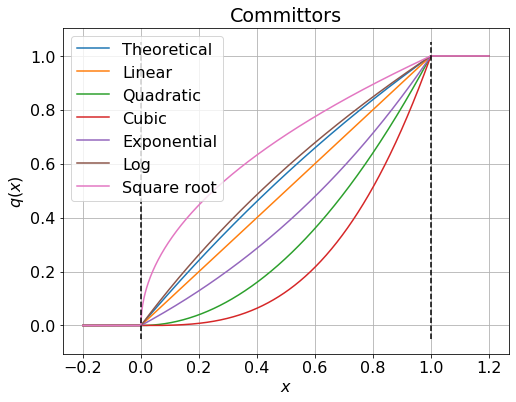

In [9]:
x = np.linspace(-0.2,1.2,1000)
y = np.zeros_like(x)
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
for i in range(len(x)):
    y[i] = qTeo(x[i],KBT)
plt.plot(x,y, label ='Theoretical')
for i in range(len(x)):
    y[i] = qLin(x[i], KBT)
plt.plot(x,y, label ='Linear')
for i in range(len(x)):
    y[i] = qQuadr(x[i], KBT)
plt.plot(x,y, label ='Quadratic')
for i in range(len(x)):
    y[i] = qCub(x[i], KBT)
plt.plot(x,y, label ='Cubic')
for i in range(len(x)):
    y[i] = qExp(x[i], KBT)   
plt.plot(x,y, label ='Exponential')
for i in range(len(x)):
    y[i] = qLog(x[i], KBT)    
plt.plot(x,y, label ='Log')
for i in range(len(x)):
    y[i] = qSqrt(x[i], KBT)   
plt.plot(x,y, label ='Square root')

plt.plot(0.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.plot(1.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.title('Committors')
plt.xlabel(r'$x$')
plt.ylabel(r'$q(x)$')
plt.legend()
plt.grid()
plt.show()

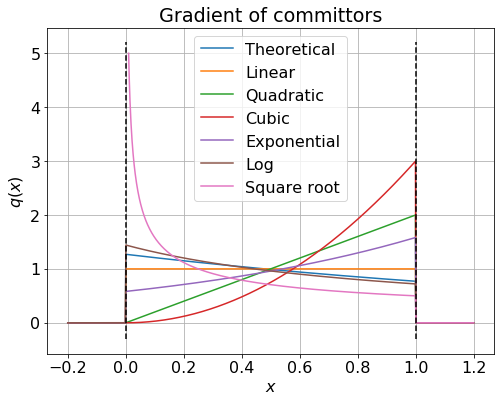

In [10]:
x = np.linspace(-0.2,1.2,1000)
y = np.zeros_like(x)
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
for i in range(len(x)):
    y[i] = dqTeo(x[i],KBT)
plt.plot(x,y, label ='Theoretical')
for i in range(len(x)):
    y[i] = dqLin(x[i], KBT)
plt.plot(x,y, label ='Linear')
for i in range(len(x)):
    y[i] = dqQuadr(x[i], KBT)
plt.plot(x,y, label ='Quadratic')
for i in range(len(x)):
    y[i] = dqCub(x[i], KBT)
plt.plot(x,y, label ='Cubic')
for i in range(len(x)):
    y[i] = dqExp(x[i], KBT)   
plt.plot(x,y, label ='Exponential')
for i in range(len(x)):
    y[i] = dqLog(x[i], KBT)   
plt.plot(x,y, label ='Log')
x = np.linspace(0.01,1.2,1000)
for i in range(len(x)):
    y[i] = dqSqrt(x[i], KBT)  
plt.plot(x,y, label ='Square root')
plt.plot(0.0*np.ones(2),np.linspace(-0.3,5.2,2),"k--")
plt.plot(1.0*np.ones(2),np.linspace(-0.3,5.2,2),"k--")
plt.title('Gradient of committors')
plt.xlabel(r'$x$')
plt.ylabel(r'$q(x)$')
plt.legend()
plt.grid()
plt.show()

In [11]:
KR = 500
KBT = 0.02
ctry = [1.0, 0.0]
DT = 0.002

Theoretically correct 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-4-1398856c5a81>", line 2:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

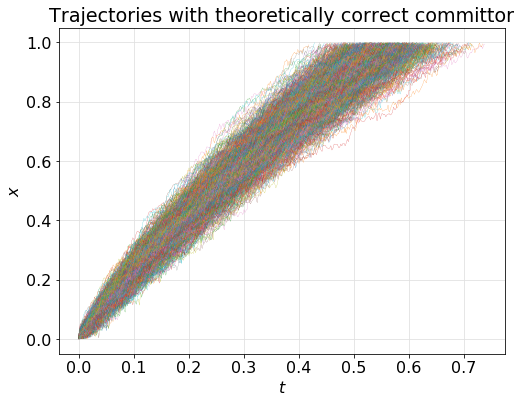

M
[[0.19613599 0.19613599]
 [0.19613599 0.19613599]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-12-624e18c61a9c>", line 42:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 3, function evaluations: 3, CG iterations: 0, optimality: 1.67e-16, constraint violation: 0.00e+00, execution time: 0.011 s.
[0.5 0.5]
Linear guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-4-1398856c5a81>", line 2:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

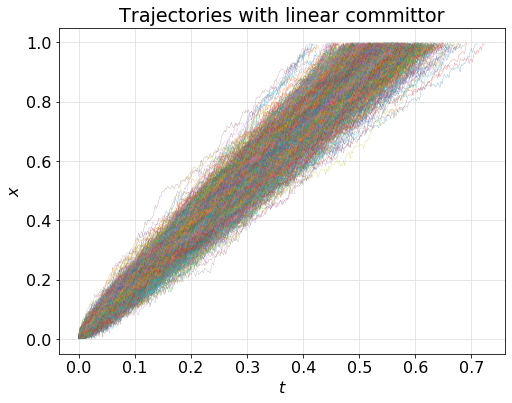

M
[[0.2 0.2]
 [0.2 0.2]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-12-624e18c61a9c>", line 115:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 3, function evaluations: 3, CG iterations: 0, optimality: 2.22e-16, constraint violation: 0.00e+00, execution time: 0.0097 s.
[0.5 0.5]

 Quadratic guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-4-1398856c5a81>", line 2:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

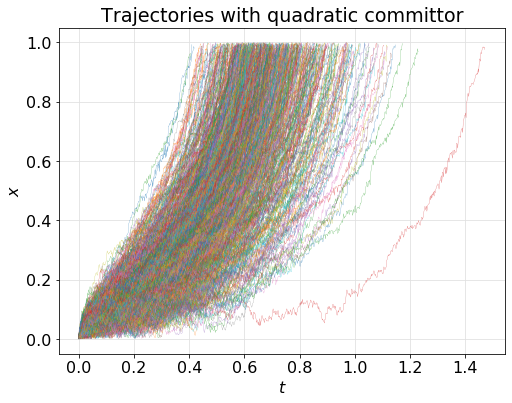

M
[[0.14117445 0.14117445]
 [0.14117445 0.14117445]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-12-624e18c61a9c>", line 188:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 3, function evaluations: 3, CG iterations: 0, optimality: 8.33e-17, constraint violation: 0.00e+00, execution time: 0.0098 s.
[0.5 0.5]

 Cubic guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-4-1398856c5a81>", line 2:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

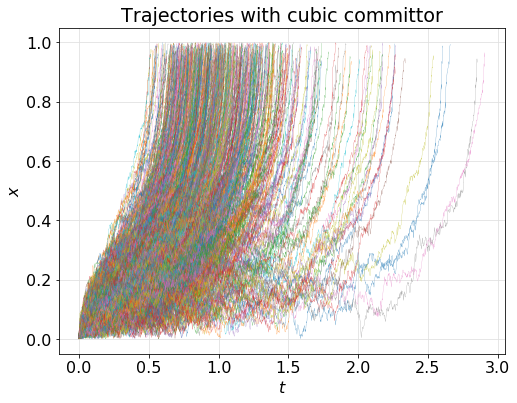

M
[[0.0836817 0.0836817]
 [0.0836817 0.0836817]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-12-624e18c61a9c>", line 261:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 3, function evaluations: 3, CG iterations: 0, optimality: 8.33e-17, constraint violation: 0.00e+00, execution time: 0.0098 s.
[0.5 0.5]

 Exp guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-4-1398856c5a81>", line 2:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

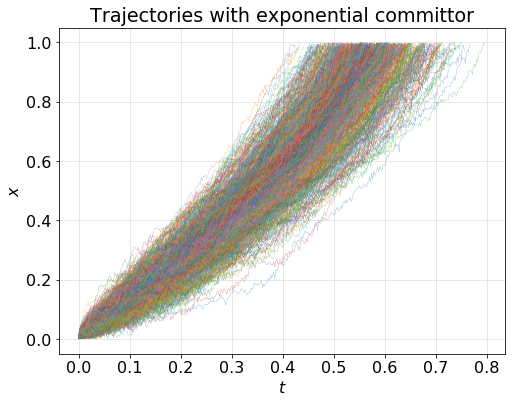

M
[[0.18458132 0.18458132]
 [0.18458132 0.18458132]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-12-624e18c61a9c>", line 334:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 3, function evaluations: 3, CG iterations: 0, optimality: 1.67e-16, constraint violation: 0.00e+00, execution time: 0.0097 s.
[0.5 0.5]

 Log guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-4-1398856c5a81>", line 2:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

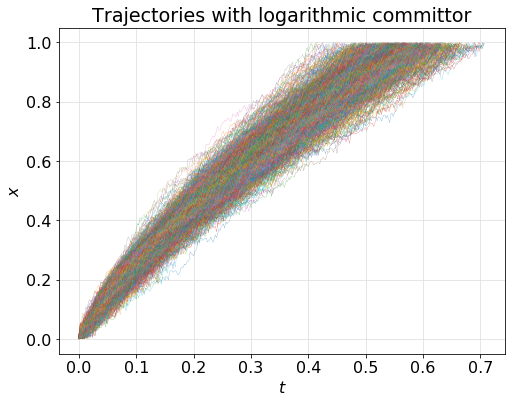

M
[[0.19197449 0.19197449]
 [0.19197449 0.19197449]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-12-624e18c61a9c>", line 409:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 3, function evaluations: 3, CG iterations: 0, optimality: 1.67e-16, constraint violation: 0.00e+00, execution time: 0.0098 s.
[0.5 0.5]

 Sqrt guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-4-1398856c5a81>", line 2:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

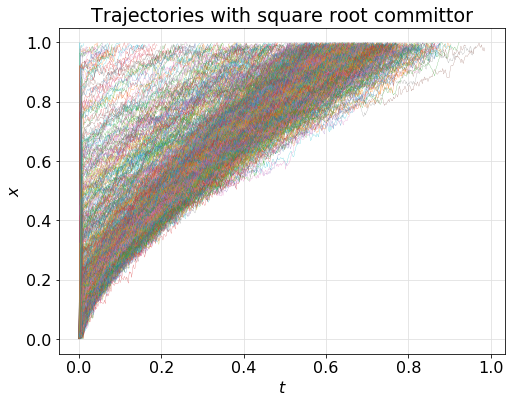

M
[[0.55017473 0.55017473]
 [0.55017473 0.55017473]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-12-624e18c61a9c>", line 484:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 3, function evaluations: 3, CG iterations: 0, optimality: 4.44e-16, constraint violation: 0.00e+00, execution time: 0.0096 s.
[0.5 0.5]


In [12]:
### Linear guess
print("Theoretically correct \n")
## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qTeo, dGuess1 = dqTeo, Guess2 = qTeo, dGuess2 = dqTeo, c = ctry,kr = KR, KbT = KBT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajTeo = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajTeo = np.concatenate((trajTeo, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title('Trajectories with theoretically correct committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
ITeo = I(ctry,M)
## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [1.0, 1.0],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)


### Linear guess
print("Linear guess \n")
## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qLin, dGuess2 = dqLin, c = ctry,kr = KR, KbT = KBT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajLin = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajLin = np.concatenate((trajLin, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title('Trajectories with linear committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
ILin = I(ctry,M)
## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [1.0, 1.0],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)

### Quadratic guess
print("\n Quadratic guess \n")

## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qQuadr, dGuess1 = dqQuadr, Guess2 = qQuadr, dGuess2 = dqQuadr, c = ctry,kr = KR, KbT = KBT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajQuadr = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajQuadr = np.concatenate((trajQuadr, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title('Trajectories with quadratic committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
IQuadr = I(ctry,M)
## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [1.0, 1.0],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)

### Cubic guess
print("\n Cubic guess \n")

## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qCub, dGuess1 = dqCub, Guess2 = qCub, dGuess2 = dqCub, c = ctry,kr = KR, KbT = KBT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajCub = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajCub = np.concatenate((trajCub, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title('Trajectories with cubic committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
ICub = I(ctry,M)
## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [1.0, 1.0],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)

### Exp guess
print("\n Exp guess \n")

## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qExp, dGuess1 = dqExp, Guess2 = qExp, dGuess2 = dqExp, c = ctry,kr = KR, KbT = KBT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajExp = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajExp = np.concatenate((trajExp, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title('Trajectories with exponential committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
IExp = I(ctry,M)

## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [1.0, 1.0],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)


### Log guess
print("\n Log guess \n")

## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qLog, dGuess1 = dqLog, Guess2 = qLog, dGuess2 = dqLog, c = ctry,kr = KR, KbT = KBT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajLog = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajLog = np.concatenate((trajLog, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title('Trajectories with logarithmic committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
ILog = I(ctry,M)

## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [1.0, 1.0],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)


### Sqrt guess
print("\n Sqrt guess \n")

## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qSqrt, dGuess1 = dqSqrt, Guess2 = qSqrt, dGuess2 = dqSqrt, c = ctry,kr = KR, KbT = KBT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajSqrt = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajSqrt = np.concatenate((trajSqrt, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title('Trajectories with square root committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
ISqrt = I(ctry,M)
## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [1.0, 1.0],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)

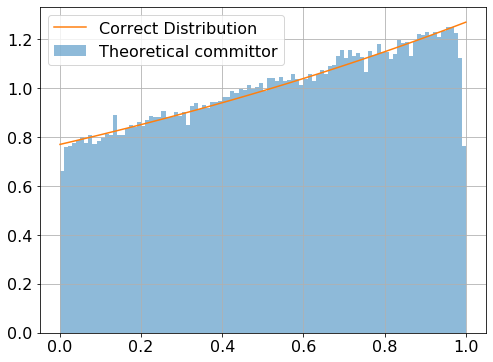

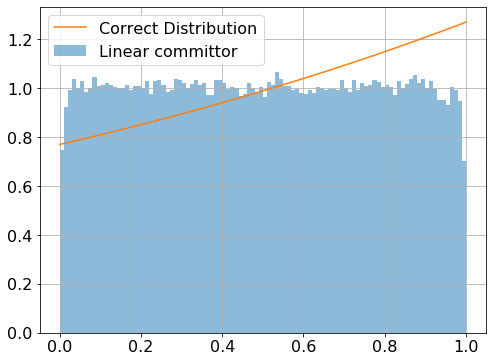

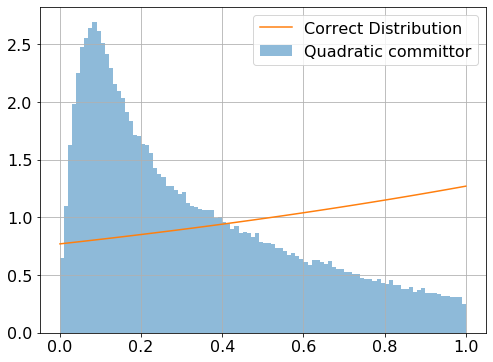

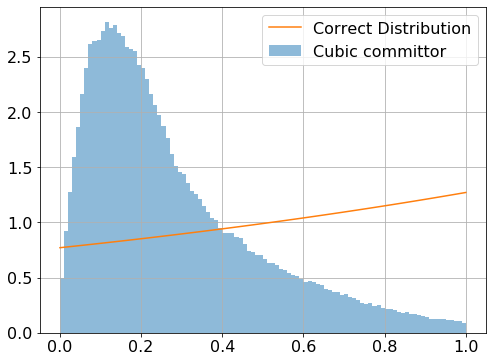

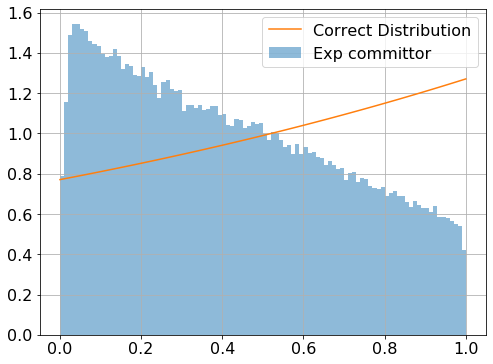

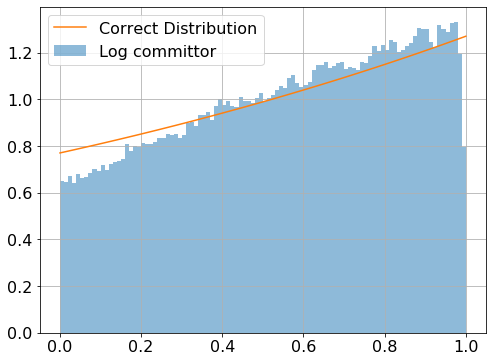

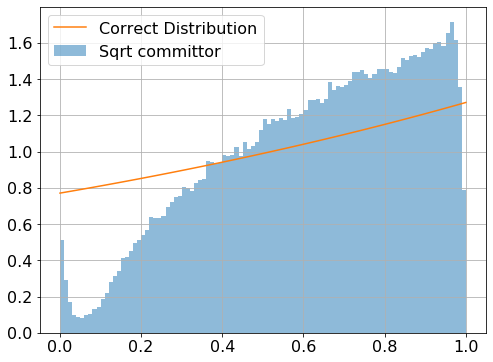

In [13]:
norm = K/KBT/(np.exp(K/KBT)-1.0)

# Sampling of transition region - histogram plot
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.hist(trajTeo, 100, density=True, alpha = 0.5, label = 'Theoretical committor')
# Expected result
x = np.linspace(0,1)
plt.plot(x,norm*np.exp(K/KBT*x), label = 'Correct Distribution')
plt.legend()
plt.grid()
plt.show()

# Sampling of transition region - histogram plot
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.hist(trajLin, 100, density=True, alpha = 0.5, label = 'Linear committor')
# Expected result
x = np.linspace(0,1)
plt.plot(x,norm*np.exp(K/KBT*x), label = 'Correct Distribution')
plt.legend()
plt.grid()
plt.show()

# Sampling of transition region - histogram plot
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.hist(trajQuadr, 100, density=True, alpha = 0.5, label = 'Quadratic committor')
# Expected result
x = np.linspace(0,1)
plt.plot(x,norm*np.exp(K/KBT*x), label = 'Correct Distribution')
plt.legend()
plt.grid()
plt.show()

# Sampling of transition region - histogram plot
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.hist(trajCub, 100, density=True, alpha = 0.5, label = 'Cubic committor')
# Expected result
x = np.linspace(0,1)
plt.plot(x,norm*np.exp(K/KBT*x), label = 'Correct Distribution')
plt.legend()
plt.grid()
plt.show()

# Sampling of transition region - histogram plot
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.hist(trajExp, 100, density=True, alpha = 0.5, label = 'Exp committor')
# Expected result
x = np.linspace(0,1)
plt.plot(x,norm*np.exp(K/KBT*x), label = 'Correct Distribution')
plt.legend()
plt.grid()
plt.show()

# Sampling of transition region - histogram plot
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.hist(trajLog, 100, density=True, alpha = 0.5, label = 'Log committor')
# Expected result
x = np.linspace(0,1)
plt.plot(x,norm*np.exp(K/KBT*x), label = 'Correct Distribution')
plt.legend()
plt.grid()
plt.show()

# Sampling of transition region - histogram plot
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.hist(trajSqrt, 100, density=True, alpha = 0.5, label = 'Sqrt committor')
# Expected result
x = np.linspace(0,1)
plt.plot(x,norm*np.exp(K/KBT*x), label = 'Correct Distribution')
plt.legend()
plt.grid()
plt.show()

In [14]:
KR = 500
KBT = 0.02
GUESS1 = qTeo
DGUESS1 = dqTeo
GUESS2 = qLin
DGUESS2 = dqLin

Cycle =  1
Cycle =  2


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-4-1398856c5a81>", line 2:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


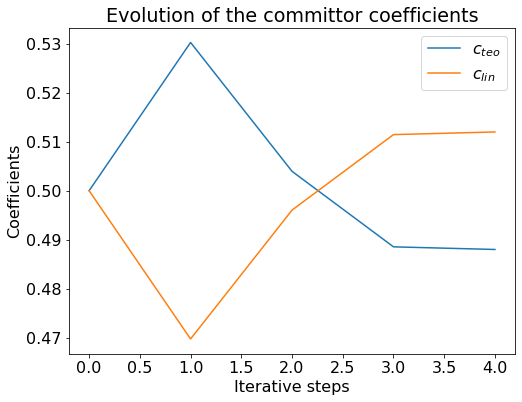

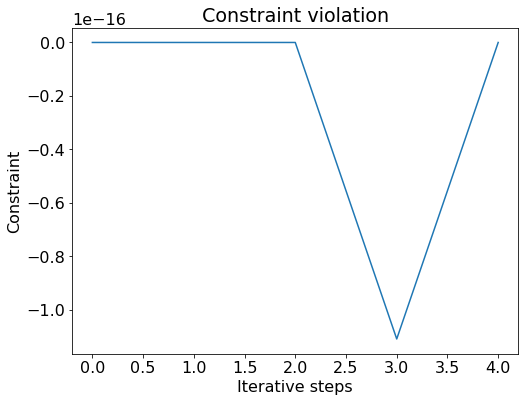

No handles with labels found to put in legend.


Final coefficients
[0.48801284 0.51198716]


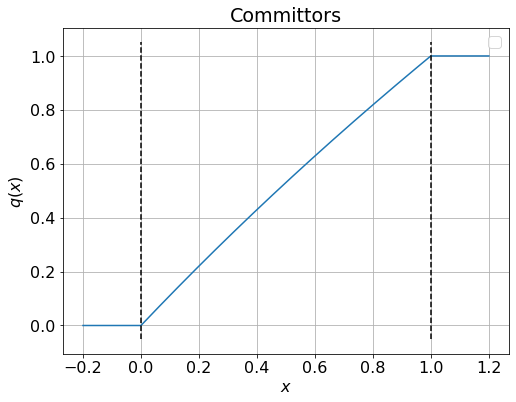

In [15]:
# Self consistent procedure
c = Self_consistent(Guess1 = GUESS1, dGuess1 = DGUESS1, Guess2 = GUESS2, dGuess2 = DGUESS2,c = [0.5, 0.5], kr = KR, KbT = KBT, ksteps=5)

# Plot of the evolution of the coefficients during the self consistent procedure
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(c[:,0], label = r"$c_{teo}$")
plt.plot(c[:,1], label = r"$c_{lin}$")
plt.title("Evolution of the committor coefficients")
plt.xlabel("Iterative steps")
plt.ylabel("Coefficients")
plt.legend()
plt.show()

# Plot of how much we violate the linear constraint
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(c[:,0]+c[:,1] - 1.0)
plt.title("Constraint violation")
plt.xlabel("Iterative steps")
plt.ylabel("Constraint")
plt.show()

# Plot the final results
print("Final coefficients")
print(c[-1,:])
# Print the corresponding committor
x = np.linspace(-0.2,1.2,1000)
y = np.zeros_like(x)
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
for i in range(len(x)):
    y[i] = c[-1,0]*GUESS1(x[i], KBT) + c[-1,1]*GUESS2(x[i], KBT)
plt.plot(x,y)
plt.plot(0.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.plot(1.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.title('Committors')
plt.xlabel(r'$x$')
plt.ylabel(r'$q(x)$')
plt.legend()
plt.grid()
plt.show()

In [16]:
KR = 500
KBT = 0.02
GUESS1 = qTeo
DGUESS1 = dqTeo
GUESS2 = qQuadr
DGUESS2 = dqQuadr

Cycle =  1
Cycle =  2


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-4-1398856c5a81>", line 2:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  13
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found

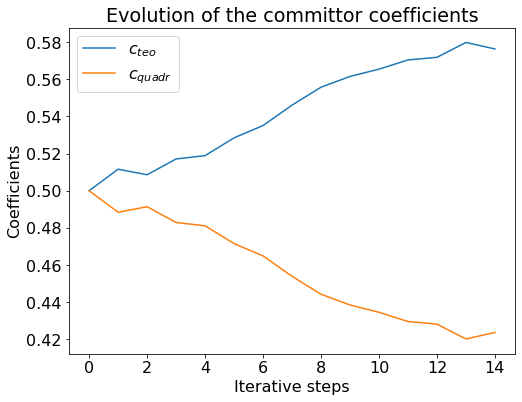

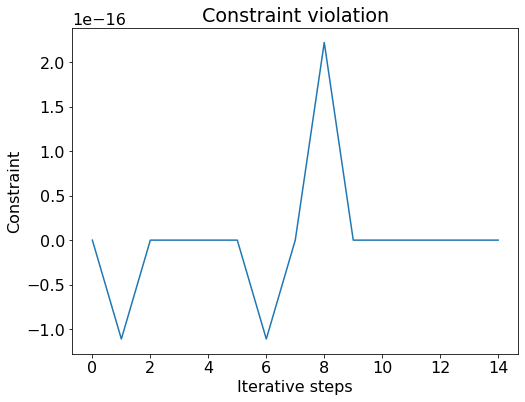

No handles with labels found to put in legend.


Final coefficients
[0.57627439 0.42372561]


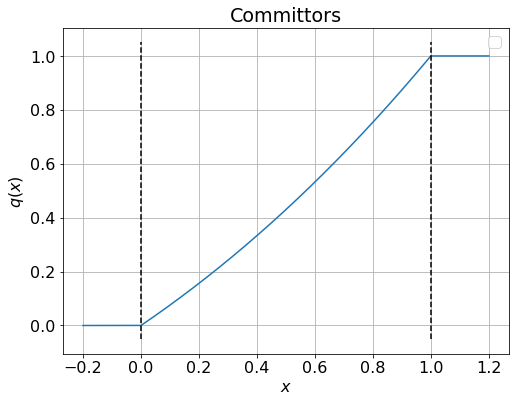

In [17]:
# Self consistent procedure
c = Self_consistent(Guess1 = GUESS1, dGuess1 = DGUESS1, Guess2 = GUESS2, dGuess2 = DGUESS2,c = [0.5, 0.5], kr = KR, KbT = KBT, ksteps=15)

# Plot of the evolution of the coefficients during the self consistent procedure
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(c[:,0], label = r"$c_{teo}$")
plt.plot(c[:,1], label = r"$c_{quadr}$")
plt.title("Evolution of the committor coefficients")
plt.xlabel("Iterative steps")
plt.ylabel("Coefficients")
plt.legend()
plt.show()

# Plot of how much we violate the linear constraint
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(c[:,0]+c[:,1] - 1.0)
plt.title("Constraint violation")
plt.xlabel("Iterative steps")
plt.ylabel("Constraint")
plt.show()

# Plot the final results
print("Final coefficients")
print(c[-1,:])
# Print the corresponding committor
x = np.linspace(-0.2,1.2,1000)
y = np.zeros_like(x)
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
for i in range(len(x)):
    y[i] = c[-1,0]*GUESS1(x[i], KBT) + c[-1,1]*GUESS2(x[i], KBT)
plt.plot(x,y)
plt.plot(0.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.plot(1.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.title('Committors')
plt.xlabel(r'$x$')
plt.ylabel(r'$q(x)$')
plt.legend()
plt.grid()
plt.show()

### Theoretical committor as function of KR

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

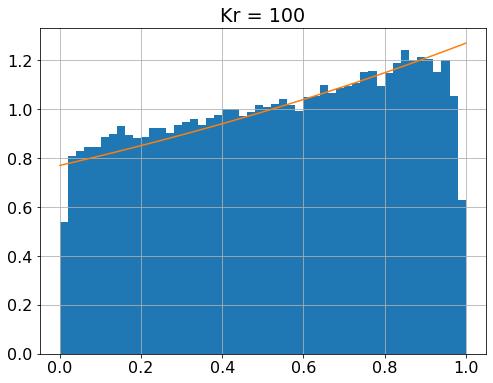

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

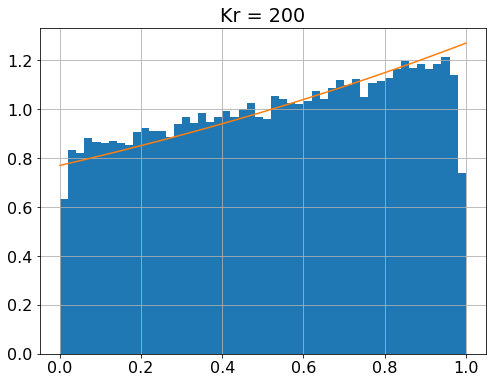

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

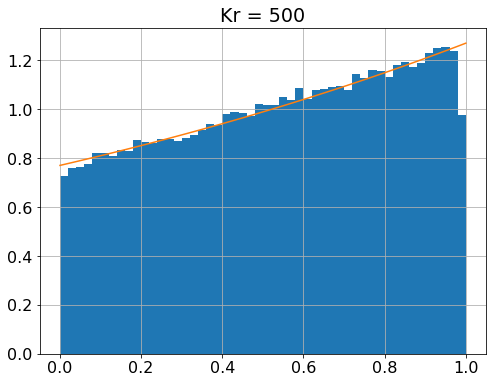

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

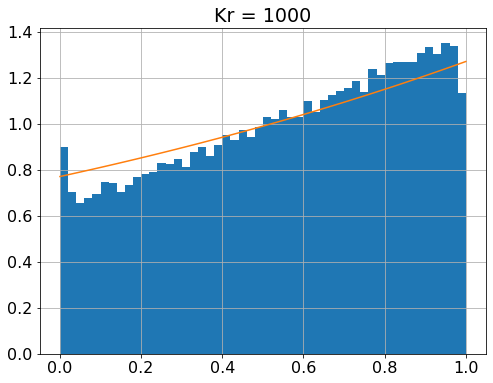

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

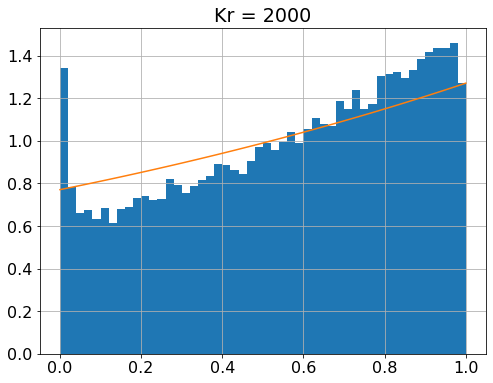

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

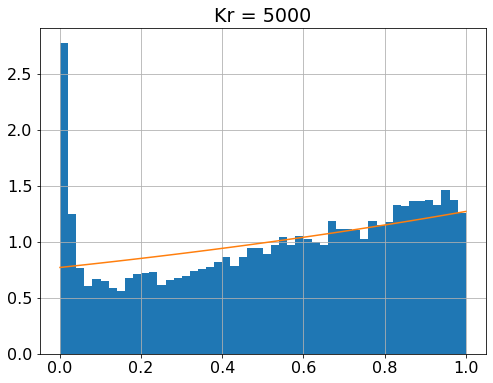

In [18]:
KBT = 0.02
x = np.linspace(0,1)
for KR in [100, 200, 500, 1000, 2000, 5000]:
    plt.figure(figsize=(8,6))
    matplotlib.rcParams.update({'font.size': 16})
    tmp = 0
    # Loop over many iterations with different initial conditions
    for i in range(1000):
        traj, M = LI_RMD(Guess1 = qTeo, dGuess1 = dqTeo, Guess2 = qTeo, dGuess2 = dqTeo, c = [1.0,0.0],kr = KR, KbT = KBT)
        if traj[0] != 0:
            if tmp==0:
                trajTeo = np.copy(traj)
                tmp = 1
            if tmp==1:
                trajTeo = np.concatenate((trajTeo, traj), axis=0)
    # Sampling of transition region - histogram plot
    plt.hist(trajTeo, 50, density=True)
    # Expected result
    norm = K/KBT/(np.exp(K/KBT)-1.0)
    plt.plot(x,norm*np.exp(K/KBT*x), label = 'Correct Distribution')
    plt.title('Kr = '+str(KR))
    plt.grid()
    plt.show()

### Theoretical committor as function of KBT

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

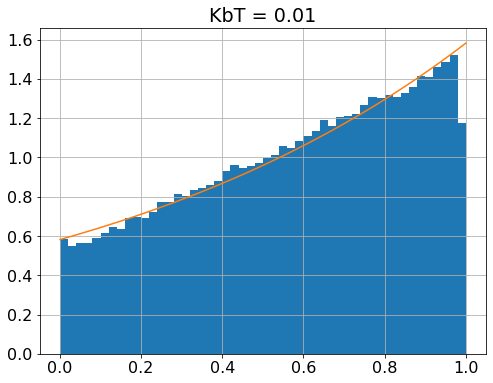

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

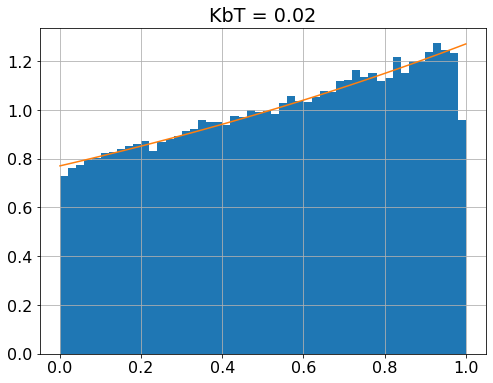

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

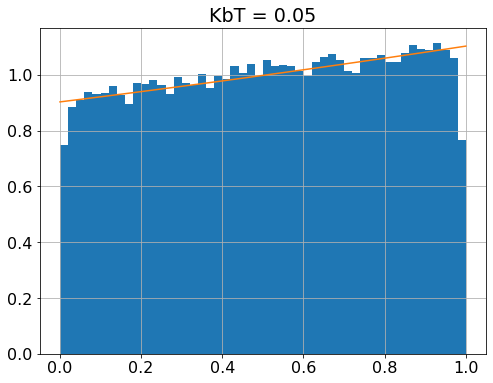

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

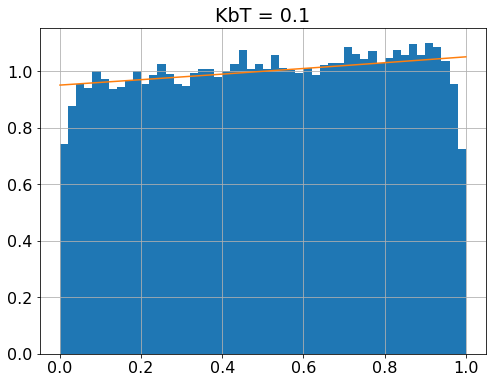

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

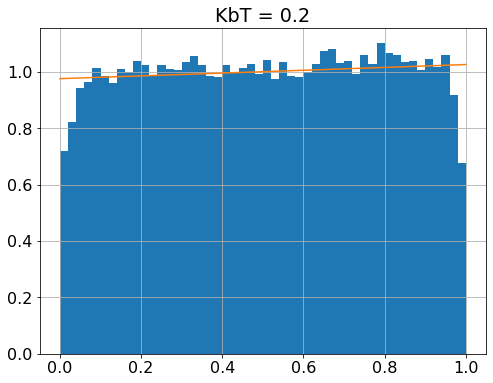

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

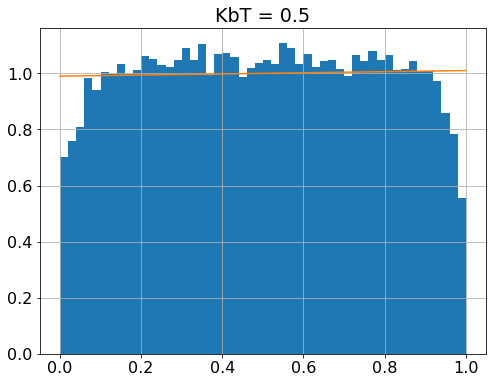

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


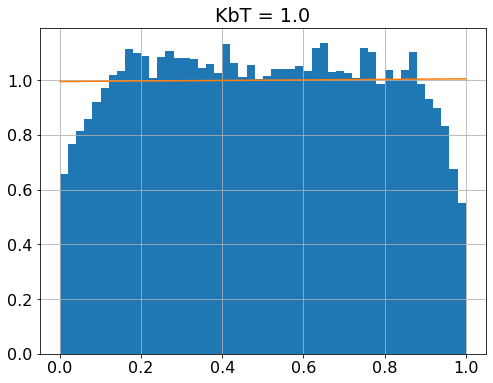

In [19]:
KR = 500
x = np.linspace(0,1)
for KBT in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]:
    plt.figure(figsize=(8,6))
    matplotlib.rcParams.update({'font.size': 16})
    tmp = 0
    # Loop over many iterations with different initial conditions
    for i in range(1000):
        traj, M = LI_RMD(Guess1 = qTeo, dGuess1 = dqTeo, Guess2 = qTeo, dGuess2 = dqTeo, c = [1.0,0.0],kr = KR, KbT = KBT)
        if traj[0] != 0:
            if tmp==0:
                trajLin = np.copy(traj)
                tmp = 1
            if tmp==1:
                trajLin = np.concatenate((trajLin, traj), axis=0)
    # Sampling of transition region - histogram plot
    plt.hist(trajLin, 50, density=True)
    # Expected result
    norm = K/KBT/(np.exp(K/KBT)-1.0)
    plt.plot(x,norm*np.exp(K/KBT*x), label = 'Correct Distribution')
    plt.title('KbT = '+str(KBT))
    plt.grid()
    plt.show()

### Linear committor as function of KR

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

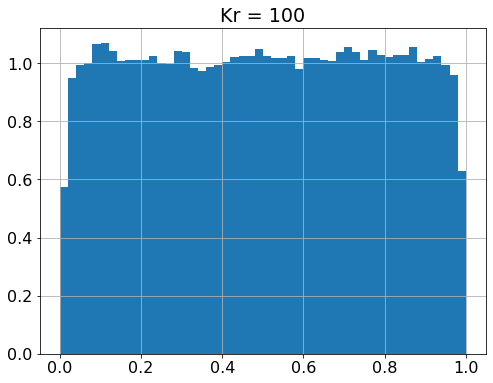

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

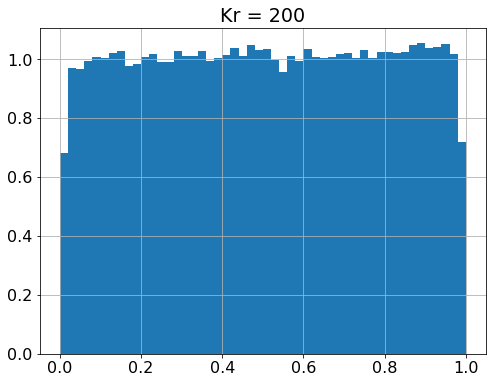

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

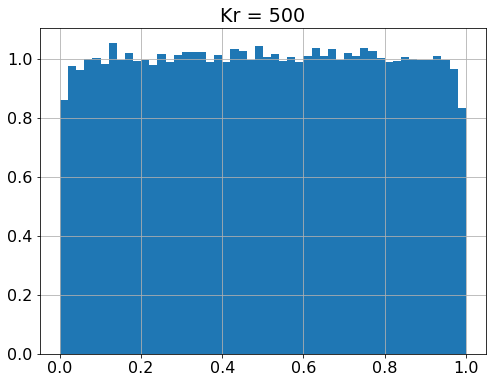

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

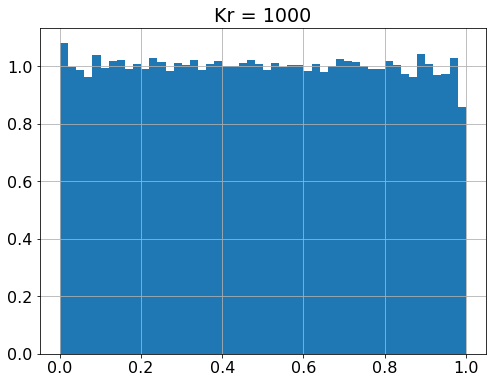

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

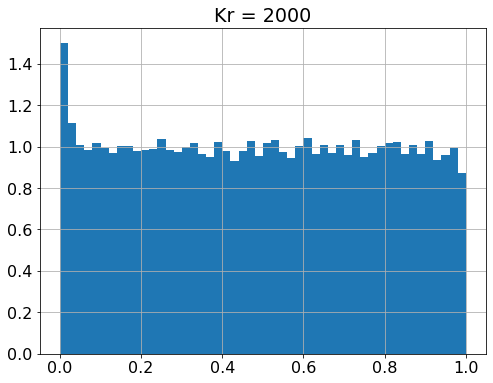

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

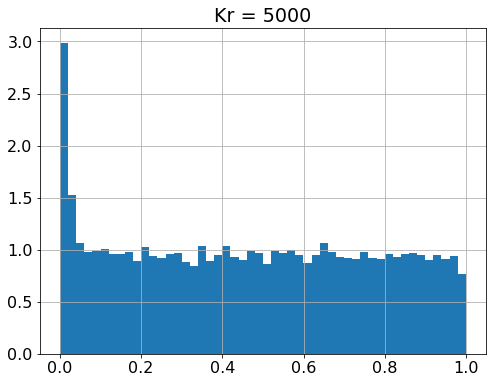

In [20]:
KBT = 0.02
for KR in [100, 200, 500, 1000, 2000, 5000]:
    plt.figure(figsize=(8,6))
    matplotlib.rcParams.update({'font.size': 16})
    tmp = 0
    # Loop over many iterations with different initial conditions
    for i in range(1000):
        traj, M = LI_RMD(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qLin, dGuess2 = dqLin, c = [1.0,0.0],kr = KR, KbT = KBT)
        if traj[0] != 0:
            if tmp==0:
                trajQuadr = np.copy(traj)
                tmp = 1
            if tmp==1:
                trajQuadr = np.concatenate((trajQuadr, traj), axis=0)
    # Sampling of transition region - histogram plot
    plt.hist(trajQuadr, 50, density=True)
    plt.title('Kr = '+str(KR))
    plt.grid()
    plt.show()

### Linear committor as function of KBT

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

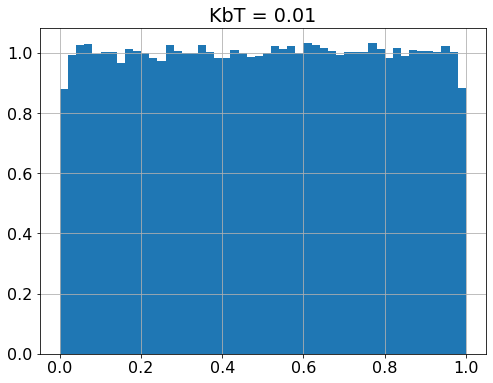

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

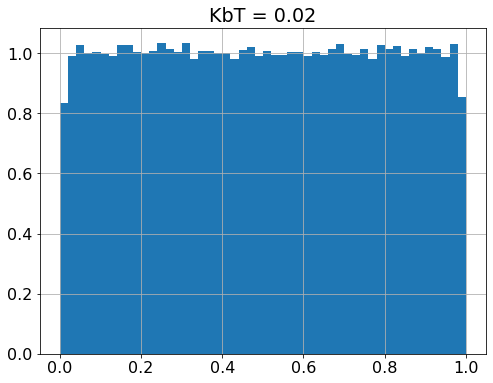

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

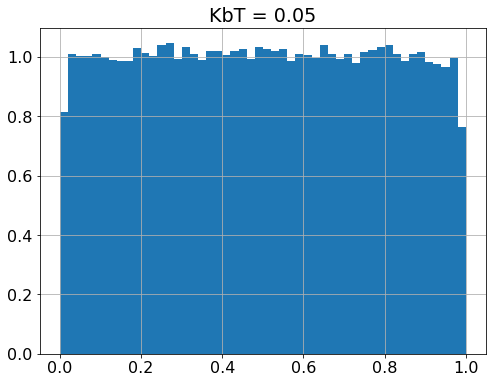

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

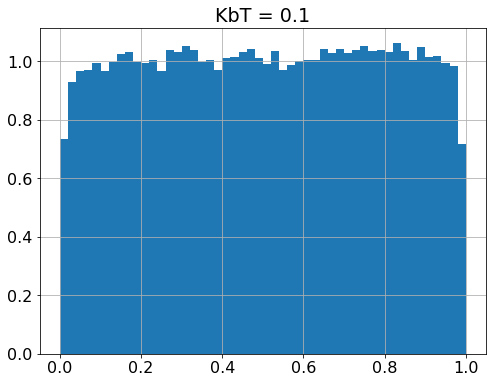

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

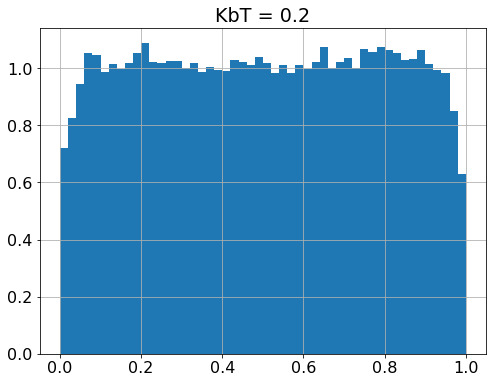

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


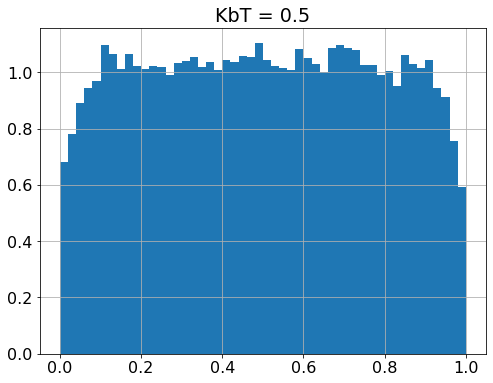

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


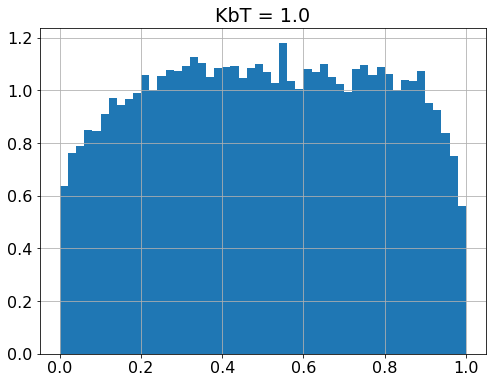

In [21]:
KR = 500
for KBT in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]:
    plt.figure(figsize=(8,6))
    matplotlib.rcParams.update({'font.size': 16})
    tmp = 0
    # Loop over many iterations with different initial conditions
    for i in range(1000):
        traj, M = LI_RMD(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qLin, dGuess2 = dqLin, c = [1.0,0.0],kr = KR, KbT = KBT)
        if traj[0] != 0:
            if tmp==0:
                trajQuadr = np.copy(traj)
                tmp = 1
            if tmp==1:
                trajQuadr = np.concatenate((trajQuadr, traj), axis=0)
    # Sampling of transition region - histogram plot
    plt.hist(trajQuadr, 50, density=True)
    plt.title('KbT = '+str(KBT))
    plt.grid()
    plt.show()

In [22]:
KBT = 0.02
D = np.sqrt(2.0*KBT)
KbTBeta = K/KBT

print("Theoretical")
print("Simulated I:= ",ITeo)
print("Theoretical I:= ", D*(np.exp(KbTBeta)* KbTBeta**2)/(-1.0 + np.exp(KbTBeta))**2)
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajTeo)):
    tmp = dqTeo(trajTeo[k],KBT)
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2           
# Average M over all the values obtained with the sampling
M *= D/len(trajTeo)
# Calculation of I based on the sampling of the linear committor
ITeoResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", ITeoResampled)
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajTeo)):
    tmp = dqTeo(trajTeo[k],KBT)
    weight = tmp*np.exp(-potential(trajTeo[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
ITeoReweight= I(ctry,M)
print("Reweighted distribution I:= ", ITeoReweight)


print("\nLinear")
print("Simulated I:= ",ILin)
print("Theoretical I:= ", D)
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajTeo)):
    tmp = dqLin(trajTeo[k],KBT)
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2           
# Average M over all the values obtained with the sampling
M *= D/len(trajTeo)
# Calculation of I based on the sampling of the linear committor
ILinResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", ILinResampled)
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajLin)):
    tmp = dqLin(trajLin[k],KBT)
    weight = tmp*np.exp(-potential(trajLin[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
ILinReweight= I(ctry,M)
print("Reweighted distribution I:= ", ILinReweight)



print("\nQuadratic")
print("Simulated I:= ",IQuadr)
print("Theoretical I:= ", D*(-8.0+4.0*np.exp(KbTBeta)*(2.0+KbTBeta*(-2.0+KbTBeta)))/((-1.0+np.exp(KbTBeta))*KbTBeta**2))
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajTeo)):
    tmp = dqQuadr(trajTeo[k],KBT)
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2  
# Average M over all the values obtained with the sampling
M *= D/len(trajTeo)
# Calculation of I based on the sampling of the linear committor
IQuadrResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", IQuadrResampled)
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajQuadr)):
    tmp = dqQuadr(trajQuadr[k],KBT)
    weight = tmp*np.exp(-potential(trajQuadr[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
IQuadrReweight= I(ctry,M)
print("Reweighted distribution I:= ", IQuadrReweight)


print("\nCubic")
print("Simulated I:= ",ICub)
print("Theoretical I:= ", D*(9.0*(-24.0+np.exp(KbTBeta)*(24.0+KbTBeta*(-24.0+KbTBeta*(12.0+KbTBeta*(-4.0+KbTBeta))))))/((-1.0+np.exp(KbTBeta))*KbTBeta**4))
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajTeo)):
    tmp = dqCub(trajTeo[k],KBT)
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2        
# Average M over all the values obtained with the sampling
M *= D/len(trajTeo)
# Calculation of I based on the sampling of the linear committor
ICubResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", ICubResampled) 
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajCub)):
    tmp = dqCub(trajCub[k],KBT)
    weight = tmp*np.exp(-potential(trajCub[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
ICubReweight= I(ctry,M)
print("Reweighted distribution I:= ", ICubReweight)


print("\nExponential")
print("Simulated I:= ",IExp)
print("Theoretical I:= ", D*(0.338697*(-1.0+np.exp(2.0+KbTBeta))*KbTBeta)/((-1.0+ np.exp(KbTBeta))*(2+KbTBeta)))
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajTeo)):
    tmp = dqExp(trajTeo[k],KBT)
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2
# Average M over all the values obtained with the sampling
M *= D/len(trajTeo)
# Calculation of I based on the sampling of the linear committor
IExpResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", IExpResampled)
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajExp)):
    tmp = dqExp(trajExp[k],KBT)
    weight = tmp*np.exp(-potential(trajExp[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
IExpReweight= I(ctry,M)
print("Reweighted distribution I:= ", IExpReweight)



print("\nLogarithmic")
print("Simulated I:= ",ILog)
print("Theoretical I:= ", D/(2.0*np.log(2.0)**2))
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajTeo)):
    tmp = dqLog(trajTeo[k],KBT)
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2
# Average M over all the values obtained with the sampling
M *= (D/len(trajTeo))
# Calculation of I based on the sampling of the linear committor
ILogResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", ILogResampled)
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajLog)):
    tmp = dqLog(trajLog[k],KBT)
    weight = tmp*np.exp(-potential(trajLog[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
ILogReweight= I(ctry,M)
print("Reweighted distribution I:= ", ILogReweight)



print("\nSquare root")
print("Simulated I:= ",ISqrt)
print("Theoretical I:= ", np.Inf)
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajTeo)):
    tmp = dqSqrt(trajTeo[k],KBT)
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2
# Average M over all the values obtained with the sampling
M *= D/len(trajTeo)
# Calculation of I based on the sampling of the linear committor
ISqrtResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", ISqrtResampled)
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajSqrt)):
    tmp = dqSqrt(trajSqrt[k],KBT)
    weight = tmp*np.exp(-potential(trajSqrt[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
ISqrtReweight= I(ctry,M)
print("Reweighted distribution I:= ", ISqrtReweight)

Theoretical
Simulated I:=  0.19613599102975318
Theoretical I:=  0.1958849044516382
Resampled with correct distribution I:=  0.19636743323064387
Reweighted distribution I:=  0.1963674332304944

Linear
Simulated I:=  0.1999999999992825
Theoretical I:=  0.2
Resampled with correct distribution I:=  0.20000000000000004
Reweighted distribution I:=  0.19999999999999998

Quadratic
Simulated I:=  0.14117445039057136
Theoretical I:=  0.3004142019116855
Resampled with correct distribution I:=  0.31135111542625993
Reweighted distribution I:=  0.40795127509925844

Cubic
Simulated I:=  0.08368169864258691
Theoretical I:=  0.4219083664982594
Resampled with correct distribution I:=  0.4495716730505497
Reweighted distribution I:=  0.4301181348313108

Exponential
Simulated I:=  0.1845813232859297
Theoretical I:=  0.23353494501086883
Resampled with correct distribution I:=  0.23830702532356168
Reweighted distribution I:=  0.231918498235487

Logarithmic
Simulated I:=  0.19197449012667886
Theoretical I:=  

In [23]:
@njit(fastmath=True)
def LI_RMD_weights(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
    # Define preliminary variables
    q = np.empty(isteps, dtype=np.float64)
    M = np.empty((isteps,2,2), dtype=np.float64)
    weights = np.empty(isteps, dtype=np.float64)
    q[0] = 0.001
    i = 0
    j = 0
    tmp = 0
    s = state(q[0]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    zmax = 0.0
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        ## Evaluate evolution of the system
        f = force(q[i])
        # Linear combination of committors
        z0 = Guess1(q[i], KbT)
        z1 = Guess2(q[i], KbT)
        z = c[0]*z0+c[1]*z1
        # Gradient components of the committors
        dGx1 = dGuess1(q[i], KbT)
        dGx2 = dGuess2(q[i], KbT)
        # Reweight term
        gradcomm = c[0]*dGx1+c[1]*dGx2
        weights[i] = gradcomm*np.exp(-potential(q[i])/KbT)
        # Matrix M
        M[i,0,0] = dGx1**2*weights[i]
        M[i,1,0] = dGx2*dGx1*weights[i]
        M[i,0,1] = dGx1*dGx2*weights[i]
        M[i,1,1] = dGx2**2*weights[i]
        if z > zmax:
            q[i+1] = q[i]+f*dt+D*np.random.normal(0,1)
            zmax = z
        else:
            q[i+1] = q[i]+f*dt+D*np.random.normal(0,1)+kr*gradcomm*(zmax - z)*dt
        i += 1
        s = state(q[i])
    
    M *= np.sqrt(2.0*KbT)  # This line technically is not needed because later we rescale everything. Kept for consistency
    
    # Output in the case we do not find a reactive coordinate, so that the function does not crash
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty(1, dtype=np.float64)
        out[0] = 0.0
        outM = np.empty((1, 2, 2), dtype=np.float64)
        outM[0,0,0] = 0.0
        outM[0,1,0] = 0.0
        outM[0,0,1] = 0.0
        outM[0,1,1] = 0.0
        outweights = np.empty(1, dtype=np.float64)
        outweights[0] = 0.0
        return out, outM, outweights
        
    return q[j+1:i-1], M[j+1:i-1,:,:], weights[j+1:i-1]

In [24]:
KR = 500
KBT = 0.02
ctry = [1.0, 0.0]
DT = 0.002

Theoretical 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD_weights'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-23-8f3e5f5cb4cb>", line 2:
@njit(fastmath=True)
def LI_RMD_weights(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


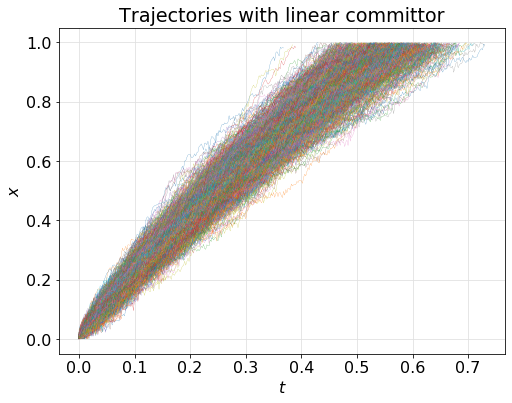

M
[[0.19609475 0.19609475]
 [0.19609475 0.19609475]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-25-bfd7e81d4212>", line 44:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 1.11e-16, constraint violation: 0.00e+00, execution time: 0.002 s.
[0.5 0.5]

 Linear guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD_weights'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-23-8f3e5f5cb4cb>", line 2:
@njit(fastmath=True)
def LI_RMD_weights(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


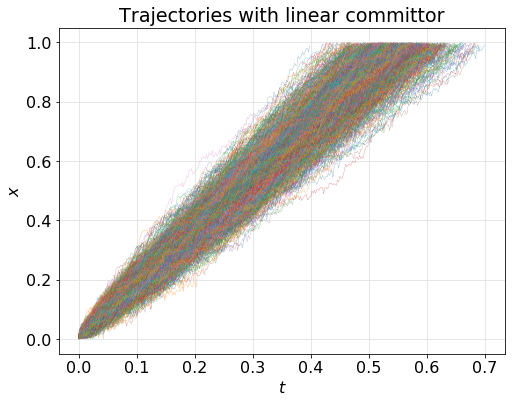

M
[[0.2 0.2]
 [0.2 0.2]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-25-bfd7e81d4212>", line 119:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 1.67e-16, constraint violation: 0.00e+00, execution time: 0.0022 s.
[0.5 0.5]

 Quadratic guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD_weights'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-23-8f3e5f5cb4cb>", line 2:
@njit(fastmath=True)
def LI_RMD_weights(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

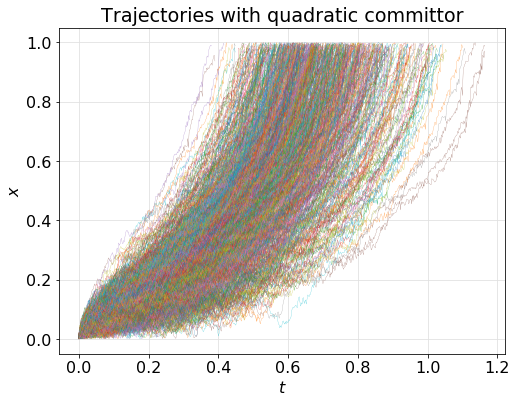

M
[[0.30697834 0.30697834]
 [0.30697834 0.30697834]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-25-bfd7e81d4212>", line 194:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 2.50e-16, constraint violation: 0.00e+00, execution time: 0.002 s.
[0.5 0.5]

 Cubic guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD_weights'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-23-8f3e5f5cb4cb>", line 2:
@njit(fastmath=True)
def LI_RMD_weights(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

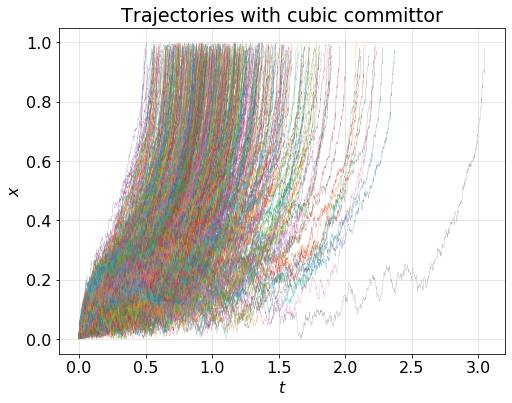

M
[[0.43091299 0.43091299]
 [0.43091299 0.43091299]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-25-bfd7e81d4212>", line 269:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 4.30e-16, constraint violation: 0.00e+00, execution time: 0.0021 s.
[0.5 0.5]

 Exp guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD_weights'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-23-8f3e5f5cb4cb>", line 2:
@njit(fastmath=True)
def LI_RMD_weights(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


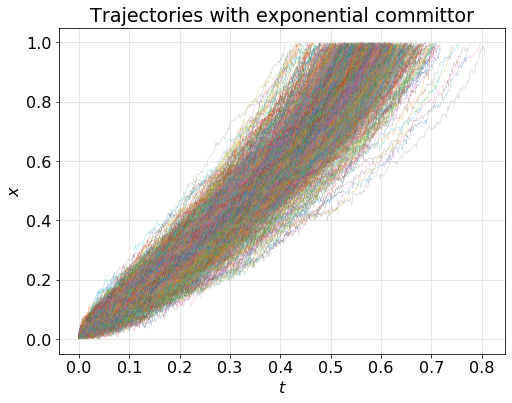

M
[[0.23222496 0.23222496]
 [0.23222496 0.23222496]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-25-bfd7e81d4212>", line 344:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 1.67e-16, constraint violation: 0.00e+00, execution time: 0.0021 s.
[0.5 0.5]

 Log guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD_weights'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-23-8f3e5f5cb4cb>", line 2:
@njit(fastmath=True)
def LI_RMD_weights(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


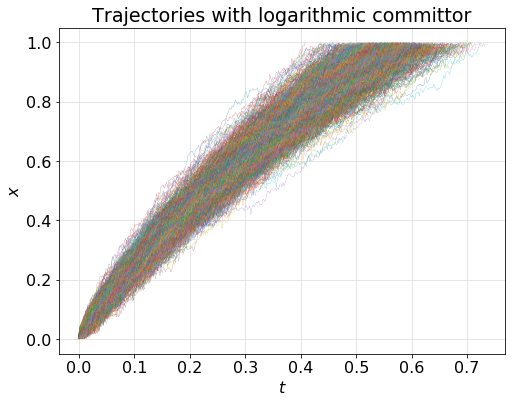

M
[[0.19569322 0.19569322]
 [0.19569322 0.19569322]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-25-bfd7e81d4212>", line 421:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 1.11e-16, constraint violation: 0.00e+00, execution time: 0.0021 s.
[0.5 0.5]


In [25]:
### Linear guess
print("Theoretical \n")
## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M, weights = LI_RMD_weights(Guess1 = qTeo, dGuess1 = dqTeo, Guess2 = qTeo, dGuess2 = dqTeo, c = ctry,kr = KR, KbT = KBT, dt = DT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajTeo = np.copy(traj)
            Mall = np.copy(M)
            weightsTeo = np.copy(weights)
            tmp = 1
        if tmp==1:
            trajTeo = np.concatenate((trajTeo, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
            weightsTeo = np.concatenate((weightsTeo, weights), axis=0)
# Title and labels
plt.title('Trajectories with linear committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= np.sum(weightsTeo)
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
ITeo = I(ctry,M)
## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [0.5, 0.5],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)


### Linear guess
print("\n Linear guess \n")
## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M, weights = LI_RMD_weights(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qLin, dGuess2 = dqLin, c = ctry,kr = KR, KbT = KBT, dt = DT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajLin = np.copy(traj)
            Mall = np.copy(M)
            weightsLin = np.copy(weights)
            tmp = 1
        if tmp==1:
            trajLin = np.concatenate((trajLin, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
            weightsLin = np.concatenate((weightsLin, weights), axis=0)
# Title and labels
plt.title('Trajectories with linear committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= np.sum(weightsLin)
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
ILin = I(ctry,M)
## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [0.5, 0.5],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)

### Quadratic guess
print("\n Quadratic guess \n")

## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M, weights = LI_RMD_weights(Guess1 = qQuadr, dGuess1 = dqQuadr, Guess2 = qQuadr, dGuess2 = dqQuadr, c = ctry,kr = KR, KbT = KBT, dt = DT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajQuadr = np.copy(traj)
            Mall = np.copy(M)
            weightsQuadr = np.copy(weights)
            tmp = 1
        if tmp==1:
            trajQuadr = np.concatenate((trajQuadr, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
            weightsQuadr = np.concatenate((weightsQuadr, weights), axis=0)
# Title and labels
plt.title('Trajectories with quadratic committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= np.sum(weightsQuadr)
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
IQuadr = I(ctry,M)
## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [0.5, 0.5],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)

### Cubic guess
print("\n Cubic guess \n")

## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M, weights = LI_RMD_weights(Guess1 = qCub, dGuess1 = dqCub, Guess2 = qCub, dGuess2 = dqCub, c = ctry,kr = KR, KbT = KBT, dt = DT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajCub = np.copy(traj)
            Mall = np.copy(M)
            weightsCub = np.copy(weights)
            tmp = 1
        if tmp==1:
            trajCub = np.concatenate((trajCub, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
            weightsCub = np.concatenate((weightsCub, weights), axis=0)
# Title and labels
plt.title('Trajectories with cubic committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= np.sum(weightsCub)
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
ICub = I(ctry,M)
## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [0.5, 0.5],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)

### Exp guess
print("\n Exp guess \n")

## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M, weights = LI_RMD_weights(Guess1 = qExp, dGuess1 = dqExp, Guess2 = qExp, dGuess2 = dqExp, c = ctry,kr = KR, KbT = KBT, dt = DT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajExp = np.copy(traj)
            Mall = np.copy(M)
            weightsExp = np.copy(weights)
            tmp = 1
        if tmp==1:
            trajExp = np.concatenate((trajExp, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
            weightsExp = np.concatenate((weightsExp, weights), axis=0)
# Title and labels
plt.title('Trajectories with exponential committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= np.sum(weightsExp)
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
IExp = I(ctry,M)

## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [0.5, 0.5],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)


### Log guess
print("\n Log guess \n")

## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M, weights = LI_RMD_weights(Guess1 = qLog, dGuess1 = dqLog, Guess2 = qLog, dGuess2 = dqLog, c = ctry,kr = KR, KbT = KBT, dt = DT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajLog = np.copy(traj)
            Mall = np.copy(M)
            weightsLog = np.copy(weights)
            tmp = 1
        if tmp==1:
            trajLog = np.concatenate((trajLog, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
            weightsLog = np.concatenate((weightsLog, weights), axis=0)
# Title and labels
plt.title('Trajectories with logarithmic committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= np.sum(weightsLog)
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
ILog = I(ctry,M)

## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [0.5, 0.5],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)

In [26]:
D = np.sqrt(2.0*KBT)

print("Theoretical")
print("Simulated I:= ",ITeo)
print("Theoretical I:= ", D*(np.exp(KbTBeta)* KbTBeta**2)/(-1.0 + np.exp(KbTBeta))**2)
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajTeo)):
    tmp = dqTeo(trajTeo[k],KBT)
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2           
# Average M over all the values obtained with the sampling
M *= D/len(trajTeo)
# Calculation of I based on the sampling of the linear committor
ITeoResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", ITeoResampled)
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajTeo)):
    tmp = dqTeo(trajTeo[k],KBT)
    weight = tmp*np.exp(-potential(trajTeo[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
ITeoReweight= I(ctry,M)
print("Reweighted distribution I:= ", ITeoReweight)


print("\nLinear")
print("Simulated I:= ",ILin)
print("Theoretical I:= ", D)
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajTeo)):
    tmp = dqLin(trajTeo[k],KBT)
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2           
# Average M over all the values obtained with the sampling
M *= D/len(trajTeo)
# Calculation of I based on the sampling of the linear committor
ILinResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", ILinResampled)
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajLin)):
    tmp = dqLin(trajLin[k],KBT)
    weight = tmp*np.exp(-potential(trajLin[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
ILinReweight= I(ctry,M)
print("Reweighted distribution I:= ", ILinReweight)



print("\nQuadratic")
print("Simulated I:= ",IQuadr)
print("Theoretical I:= ", 4.0/3.0*D)
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajTeo)):
    tmp = dqQuadr(trajTeo[k],KBT)
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2  
# Average M over all the values obtained with the sampling
M *= D/len(trajTeo)
# Calculation of I based on the sampling of the linear committor
IQuadrResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", IQuadrResampled)
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajQuadr)):
    tmp = dqQuadr(trajQuadr[k],KBT)
    weight = tmp*np.exp(-potential(trajQuadr[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
IQuadrReweight= I(ctry,M)
print("Reweighted distribution I:= ", IQuadrReweight)


print("\nCubic")
print("Simulated I:= ",ICub)
print("Theoretical I:= ", 9.0/5.0*D)
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajTeo)):
    tmp = dqCub(trajTeo[k],KBT)
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2        
# Average M over all the values obtained with the sampling
M *= D/len(trajTeo)
# Calculation of I based on the sampling of the linear committor
ICubResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", ICubResampled) 
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajCub)):
    tmp = dqCub(trajCub[k],KBT)
    weight = tmp*np.exp(-potential(trajCub[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
ICubReweight= I(ctry,M)
print("Reweighted distribution I:= ", ICubReweight)


print("\nExponential")
print("Simulated I:= ",IExp)
print("Theoretical I:= ", D/2.0*(np.exp(2)-1.0)/(np.exp(1.0)-1.0)**2)
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajTeo)):
    tmp = dqExp(trajTeo[k],KBT)
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2
# Average M over all the values obtained with the sampling
M *= D/len(trajTeo)
# Calculation of I based on the sampling of the linear committor
IExpResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", IExpResampled)
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajExp)):
    tmp = dqExp(trajExp[k],KBT)
    weight = tmp*np.exp(-potential(trajExp[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
IExpReweight= I(ctry,M)
print("Reweighted distribution I:= ", IExpReweight)



print("\nLogarithmic")
print("Simulated I:= ",ILog)
print("Theoretical I:= ", D/(2.0*np.log(2.0)**2))
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajTeo)):
    tmp = dqLog(trajTeo[k],KBT)
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2
# Average M over all the values obtained with the sampling
M *= (D/len(trajTeo))
# Calculation of I based on the sampling of the linear committor
ILogResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", ILogResampled)
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajLog)):
    tmp = dqLog(trajLog[k],KBT)
    weight = tmp*np.exp(-potential(trajLog[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
ILogReweight= I(ctry,M)
print("Reweighted distribution I:= ", ILogReweight)

Theoretical
Simulated I:=  0.19609475038276583
Theoretical I:=  0.1958849044516382
Resampled with correct distribution I:=  0.1960947503827683
Reweighted distribution I:=  0.19609475038234037

Linear
Simulated I:=  0.20000000000000473
Theoretical I:=  0.2
Resampled with correct distribution I:=  0.2
Reweighted distribution I:=  0.2

Quadratic
Simulated I:=  0.30697833676232666
Theoretical I:=  0.26666666666666666
Resampled with correct distribution I:=  0.2972449273083817
Reweighted distribution I:=  0.3069783367623255

Cubic
Simulated I:=  0.4309129897026674
Theoretical I:=  0.36000000000000004
Resampled with correct distribution I:=  0.41176955049824104
Reweighted distribution I:=  0.4309129897026981

Exponential
Simulated I:=  0.23222496446973367
Theoretical I:=  0.21639534137386535
Resampled with correct distribution I:=  0.23186066096163926
Reweighted distribution I:=  0.23222496446972896

Logarithmic
Simulated I:=  0.19569322079854554
Theoretical I:=  0.2081368981005608
Resampled

In [27]:
def Boltz_sample_weights(Guess1, dGuess1, Guess2, dGuess2, c = [0.5, 0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000, jsteps = 1000):
    # Sampling of transition region
    tmp = 0
    for j in range(jsteps):
        traj, M, weights = LI_RMD_weights(Guess1, dGuess1, Guess2, dGuess2, c = c, dt = dt, KbT = KbT, kr = kr, isteps= isteps)
        if traj[0] != 0:
            if tmp==0:
                trajall = np.copy(traj)
                Mall = np.copy(M)
                weightsall = np.copy(weights)
                tmp = 1
            if tmp==1:
                trajall = np.concatenate((trajall, traj), axis=0)
                Mall = np.concatenate((Mall, M), axis=0)
                weightsall = np.concatenate((weightsall, weights), axis=0)
        del traj, M, weights         
        
    # Evaluation of M
    M = np.zeros((2,2), dtype=np.float64)
    # Average all the values of M
    for k in range(Mall.shape[0]):
        for i in range(2):
            for j in range(2):
                M[i,j] += Mall[k,i,j]
            
    
    # Average M over all the values obtained with the sampling
    M /= np.sum(weightsall)

    # Minimization part
    cout = minimize(I, c, M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=LinearConstraint([1.0, 1.0], 1.0, 1.0),
               options={'verbose': 0}, bounds=Bounds([0.0, 0.0], [1.0, 1.0]))
    
    
    return np.array(cout.x)

In [28]:
KR = 500
KBT = 0.02
ctry = [0.5, 0.5]
DT = 0.002

In [29]:
c = Boltz_sample_weights(Guess1 = qQuadr, dGuess1 = dqQuadr, Guess2 = qQuadr, dGuess2 = dqQuadr, c = ctry ,kr=KR, KbT = KBT)
print(c)

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD_weights'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-23-8f3e5f5cb4cb>", line 2:
@njit(fastmath=True)
def LI_RMD_weights(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

In [30]:
def Self_consistent_weights(Guess1, dGuess1, Guess2, dGuess2, c = [0.5, 0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000, jsteps = 1000, ksteps = 30, alpha = 0.5):       
    cout = np.empty((ksteps, 2), dtype=np.float64)
    # Save the initial conditions
    cout[0,0] = c[0]
    cout[0,1] = c[1]
    print("Cycle = ", 1)
    # I do the first iteration
    print("Cycle = ", 2)
    cout[1,:] = Boltz_sample_weights(Guess1, dGuess1, Guess2, dGuess2, c = c, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    # I iterate the previous procedure many times
    for k in range(ksteps - 2):
        print("Cycle = ", k + 3)
        cout[k+2,:] = Boltz_sample_weights(Guess1, dGuess1, Guess2, dGuess2, c = alpha*cout[k+1,:] + (1.0 - alpha)*cout[k,:], dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    
    return cout

In [31]:
KR = 500
KBT = 0.02
GUESS1 = qTeo
DGUESS1 = dqTeo
GUESS2 = qQuadr
DGUESS2 = dqQuadr

Cycle =  1
Cycle =  2


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD_weights'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-23-8f3e5f5cb4cb>", line 2:
@njit(fastmath=True)
def LI_RMD_weights(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  3
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  4
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajec

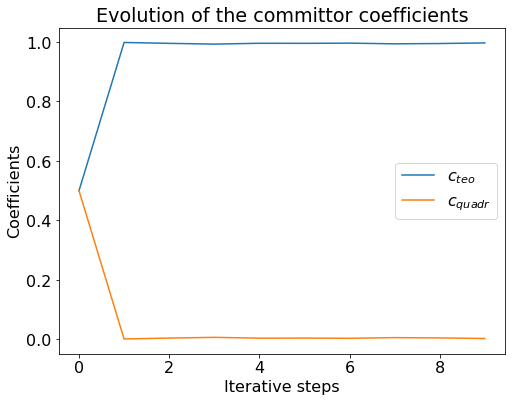

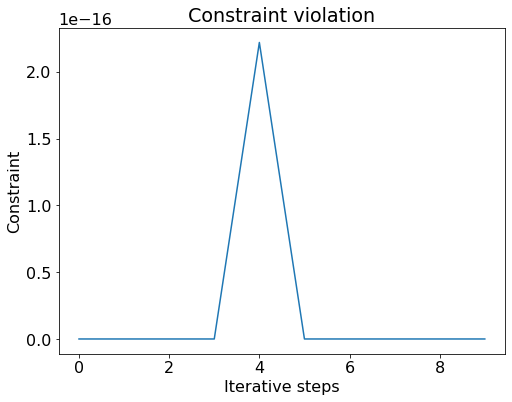

No handles with labels found to put in legend.


Final coefficients
[0.99674036 0.00325964]


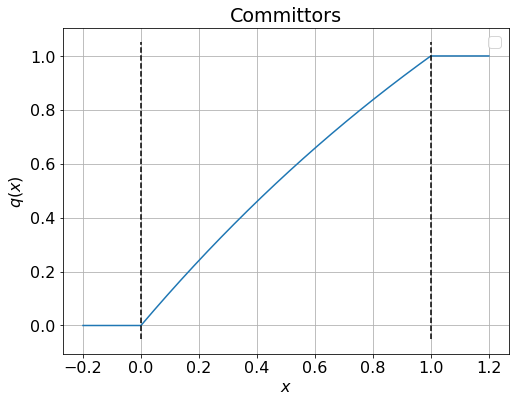

In [32]:
# Self consistent procedure
c = Self_consistent_weights(Guess1 = GUESS1, dGuess1 = DGUESS1, Guess2 = GUESS2, dGuess2 = DGUESS2,c = [0.5, 0.5], kr = KR, KbT = KBT, ksteps = 10)

# Plot of the evolution of the coefficients during the self consistent procedure
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(c[:,0], label = r"$c_{teo}$")
plt.plot(c[:,1], label = r"$c_{quadr}$")
plt.title("Evolution of the committor coefficients")
plt.xlabel("Iterative steps")
plt.ylabel("Coefficients")
plt.legend()
plt.show()

# Plot of how much we violate the linear constraint
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(c[:,0]+c[:,1] - 1.0)
plt.title("Constraint violation")
plt.xlabel("Iterative steps")
plt.ylabel("Constraint")
plt.show()

# Plot the final results
print("Final coefficients")
print(c[-1,:])
# Print the corresponding committor
x = np.linspace(-0.2,1.2,1000)
y = np.zeros_like(x)
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
for i in range(len(x)):
    y[i] = c[-1,0]*GUESS1(x[i], KBT) + c[-1,1]*GUESS2(x[i], KBT)
plt.plot(x,y)
plt.plot(0.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.plot(1.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.title('Committors')
plt.xlabel(r'$x$')
plt.ylabel(r'$q(x)$')
plt.legend()
plt.grid()
plt.show()

In [33]:
KR = 500
KBT = 0.02
GUESS1 = qTeo
DGUESS1 = dqTeo
GUESS2 = qLog
DGUESS2 = dqLog

Cycle =  1
Cycle =  2


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD_weights'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-23-8f3e5f5cb4cb>", line 2:
@njit(fastmath=True)
def LI_RMD_weights(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  3
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  4
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  5
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  6
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory fou

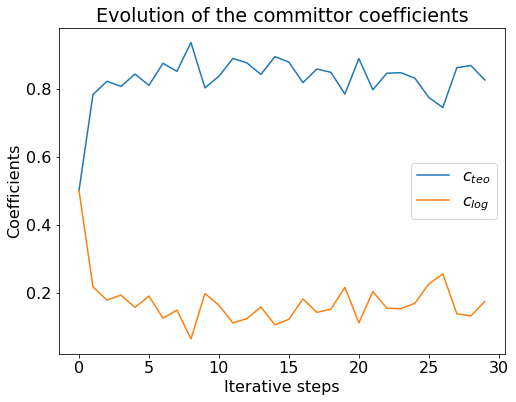

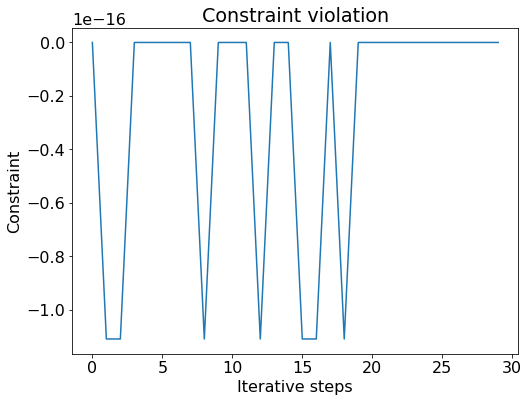

No handles with labels found to put in legend.


Final coefficients
[0.82620165 0.17379835]


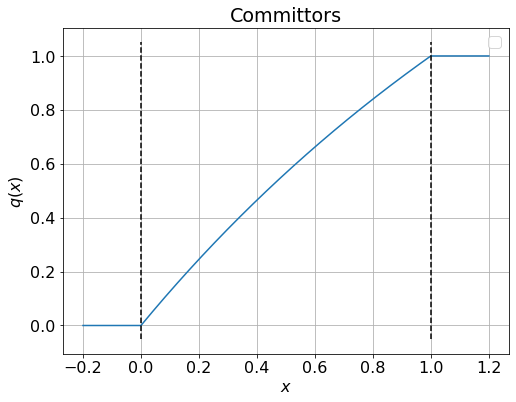

In [34]:
# Self consistent procedure
c = Self_consistent_weights(Guess1 = GUESS1, dGuess1 = DGUESS1, Guess2 = GUESS2, dGuess2 = DGUESS2,c = [0.5, 0.5], kr = KR, KbT = KBT)

# Plot of the evolution of the coefficients during the self consistent procedure
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(c[:,0], label = r"$c_{teo}$")
plt.plot(c[:,1], label = r"$c_{log}$")
plt.title("Evolution of the committor coefficients")
plt.xlabel("Iterative steps")
plt.ylabel("Coefficients")
plt.legend()
plt.show()

# Plot of how much we violate the linear constraint
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(c[:,0]+c[:,1] - 1.0)
plt.title("Constraint violation")
plt.xlabel("Iterative steps")
plt.ylabel("Constraint")
plt.show()

# Plot the final results
print("Final coefficients")
print(c[-1,:])
# Print the corresponding committor
x = np.linspace(-0.2,1.2,1000)
y = np.zeros_like(x)
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
for i in range(len(x)):
    y[i] = c[-1,0]*GUESS1(x[i], KBT) + c[-1,1]*GUESS2(x[i], KBT)
plt.plot(x,y)
plt.plot(0.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.plot(1.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.title('Committors')
plt.xlabel(r'$x$')
plt.ylabel(r'$q(x)$')
plt.legend()
plt.grid()
plt.show()

### Linear combination of all the guesses

In [35]:
@njit(fastmath=True)
def ListGuess(n, q, KbT):
    if n == 0:
        return qTeo(q, KbT)
    elif n == 1:
        return qLin(q, KbT)
    elif n == 2:
        return qQuadr(q, KbT)
    elif n == 3:
        return qCub(q, KbT)
    elif n == 4:
        return qExp(q, KbT)
    elif n == 5:
        return qLog(q, KbT)
    else:
        return qSqrt(q, KbT)
    
@njit(fastmath=True)
def ListdGuess(n, q, KbT):
    if n == 0:
        return dqTeo(q, KbT)
    elif n == 1:
        return dqLin(q, KbT)
    elif n == 2:
        return dqQuadr(q, KbT)
    elif n == 3:
        return dqCub(q, KbT)
    elif n == 4:
        return dqExp(q, KbT)
    elif n == 5:
        return dqLog(q, KbT)
    else:
        return dqSqrt(q, KbT)   

In [36]:
@njit(fastmath=True)
def LI_RMDN(c, dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
    ## Number of committor functions given as input
    n = len(c)
    
    # Define preliminary variables
    q = np.empty(isteps, dtype=np.float64)
    M = np.empty((isteps,n,n), dtype=np.float64)
    weights = np.empty(isteps, dtype=np.float64)
    dGx = np.empty(n, dtype=np.float64)
    
    q[0] = 0.001
    i = 0
    j = 0
    tmp = 0
    s = state(q[0]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    zmax = 0.0
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        ## Evaluate evolution of the system
        f = force(q[i])
         # Evaluate z
        z = 0.0
        for k in range(n):
            z += c[k]*ListGuess(k, q[i], KbT)
        # Gradient components of the committors
        for k in range(n):
            dGx[k] = ListdGuess(k, q[i], KbT)
        # Reweight term
        gradcomm = 0.0
        for k in range(n):
            gradcomm += c[k]*dGx[k]
        weights[i] = gradcomm*np.exp(-potential(q[i])/KbT)
        # Evaluating M Matrix
        for k in range(n):
            for l in range(n):
                M[i,k,l] = dGx[k]*dGx[l]*weights[i]
        if z > zmax:
            q[i+1] = q[i]+f*dt+D*np.random.normal(0,1)
            zmax = z
        else:
            q[i+1] = q[i]+f*dt+D*np.random.normal(0,1)+kr*gradcomm*(zmax - z)*dt
        i += 1
        s = state(q[i])
    
    M *= np.sqrt(2.0*KbT)  # This line technically is not needed because later we rescale everything. Kept for consistency
    
    # Output in the case we do not find a reactive coordinate, so that the function does not crash
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty(1, dtype=np.float64)
        out[0] = 0.0
        outM = np.empty((1, n, n), dtype=np.float64)
        for k in range(n):
            for l in range(n):
                M[i,k,l] = 0.0
        outweights = np.empty(1, dtype=np.float64)
        outweights[0] = 0.0
        return out, outM, outweights
        
    return q[j+1:i-1], M[j+1:i-1,:,:], weights[j+1:i-1]

In [37]:
KR = 500
KBT = 0.02
ctry = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
DT = 0.002

Theoretical guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMDN'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-36-2cb77844fa6e>", line 2:
@njit(fastmath=True)
def LI_RMDN(c, dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


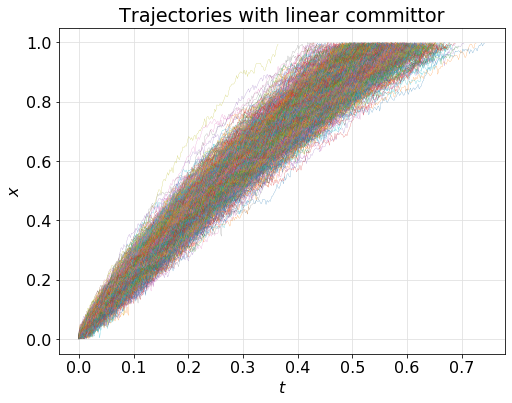

M
[[0.19582828 0.19589217 0.19600781 0.19520794 0.19580479 0.19572009
  0.19153469]
 [0.19589217 0.2        0.21641904 0.22412416 0.2079858  0.19428404
  0.18081838]
 [0.19600781 0.21641904 0.29883221 0.34256106 0.25734556 0.18850994
  0.14000595]
 [0.19520794 0.22412416 0.34256106 0.41552409 0.28460469 0.18557511
  0.13252887]
 [0.19580479 0.2079858  0.25734556 0.28460469 0.23267416 0.19143108
  0.16270378]
 [0.19572009 0.19428404 0.18850994 0.18557511 0.19143108 0.19626561
  0.19724061]
 [0.19153469 0.18081838 0.14000595 0.13252887 0.16270378 0.19724061
  0.55536384]]


In [38]:
### Linear guess
print("Theoretical guess \n")
## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M, weights = LI_RMDN(c = ctry, kr = KR, KbT = KBT, dt = DT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            Mall = np.copy(M)
            weightsall = np.copy(weights)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
            weightsall = np.concatenate((weightsall, weights), axis=0)
# Title and labels
plt.title('Trajectories with linear committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Evaluation of M
n = len(ctry)
M = np.zeros((n,n), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(n):
        for j in range(n):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= np.sum(weightsall)
    
print("M")
print(M)

In [39]:
def Boltz_sampleN(c, dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000, jsteps = 1000):
    # Sampling of transition region
    tmp = 0
    for j in range(jsteps):
        traj, M, weights = LI_RMDN(c = c, dt = dt, KbT = KbT, kr = kr, isteps= isteps)
        if traj[0] != 0:
            if tmp==0:
                trajall = np.copy(traj)
                Mall = np.copy(M)
                weightsall = np.copy(weights)
                tmp = 1
            if tmp==1:
                trajall = np.concatenate((trajall, traj), axis=0)
                Mall = np.concatenate((Mall, M), axis=0)
                weightsall = np.concatenate((weightsall, weights), axis=0)
        del traj, M, weights
    
    # Evaluation of M
    n = len(ctry)
    M = np.zeros((n,n), dtype=np.float64)
    for k in range(Mall.shape[0]):
        for i in range(n):
            for j in range(n):
                M[i,j] += Mall[k,i,j]
            
    # Matrices used for the minimization procedure
    A = [1.0 for i in range(n)]
    B = [0.0 for i in range(n)]
    # Minimization procedure
    cout = minimize(I, c, M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=LinearConstraint(A, 1.0, 1.0),
               options={'verbose': 0}, bounds=Bounds(B, A))
    
    
    return np.array(cout.x)

In [40]:
c = Boltz_sampleN(c = [1.0/7.0, 1.0/7.0, 1.0/7.0, 1.0/7.0, 1.0/7.0, 1.0/7.0, 1.0/7.0], kr=KR, KbT = KBT)
print(c)

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMDN'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-36-2cb77844fa6e>", line 2:
@njit(fastmath=True)
def LI_RMDN(c, dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
[1.85685228e-01 7.80849779e-10 6.22253279e-09 3.69081667e-02
 4.07538492e-08 7.77406557e-01 5.02511644e-13]


In [41]:
def Self_consistentN(c, dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000, jsteps = 1000, ksteps = 30, alpha = 0.5):       
    n = len(c)
    cout = np.empty((ksteps, n), dtype=np.float64)
    for i in range(n):
        cout[0,i] = c[i]
    
    print("Cycle = ", 1)
    # I do the first iteration
    print("Cycle = ", 2)
    cout[1,:] = Boltz_sampleN(c = c, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    # I iterate the previous procedure many times
    for k in range(ksteps - 2):
        print("Cycle = ", k + 3)
        cout[k+2,:] = Boltz_sampleN(c = alpha*cout[k+1,:] + (1.0 - alpha)*cout[k,:], dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    
    return cout

In [42]:
KR = 500
KBT = 0.02
ctry = [1.0/7.0, 1.0/7.0, 1.0/7.0, 1.0/7.0, 1.0/7.0, 1.0/7.0, 1.0/7.0]
n = len(ctry)

Cycle =  1
Cycle =  2
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  3
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  4
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  5
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive tra

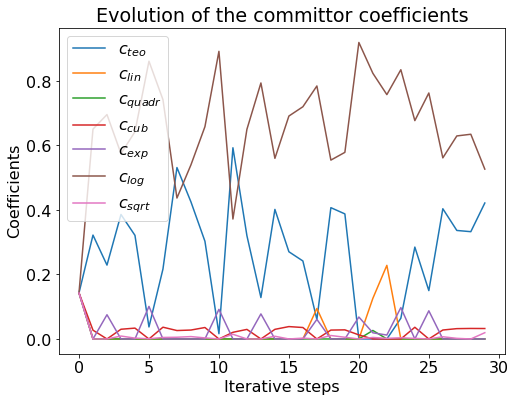

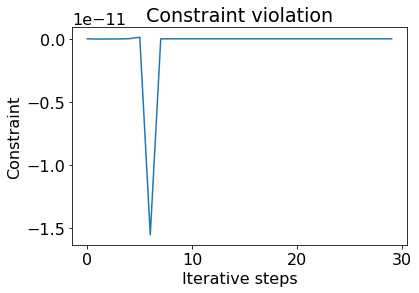

Final coefficients
[4.21518578e-01 2.24642758e-06 1.47834747e-06 3.24059789e-02
 4.03384785e-06 5.26622677e-01 1.94450078e-02]


No handles with labels found to put in legend.


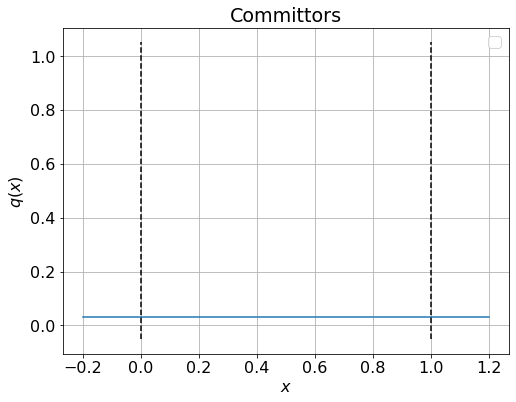

In [44]:
# Self consistent procedure
c = Self_consistentN(c = ctry, kr = KR, KbT = KBT)

# Plot of the evolution of the coefficients during the self consistent procedure
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(c[:,0], label = r"$c_{teo}$")
plt.plot(c[:,1], label = r"$c_{lin}$")
plt.plot(c[:,2], label = r"$c_{quadr}$")
plt.plot(c[:,3], label = r"$c_{cub}$")
plt.plot(c[:,4], label = r"$c_{exp}$")
plt.plot(c[:,5], label = r"$c_{log}$")
plt.plot(c[:,6], label = r"$c_{sqrt}$")
plt.title("Evolution of the committor coefficients")
plt.xlabel("Iterative steps")
plt.ylabel("Coefficients")
plt.legend()
plt.show()

# Plot of how much we violate the linear constraint
constraint = np.zeros_like(c[:,0])
for i in range(c.shape[1]):
    constraint[i] = np.sum(c[i,:])-1.0
plt.figure()
plt.plot(constraint)
plt.title("Constraint violation")
plt.xlabel("Iterative steps")
plt.ylabel("Constraint")
plt.show()

# Plot the final results
print("Final coefficients")
print(c[-1,:])
# Print the corresponding committor
x = np.linspace(-0.2,1.2,1000)
y = np.zeros_like(x)
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
for i in range(len(x)):
    for j in range(5): 
        y[i] += c[-1,j]*ListGuess(x[i],j, KBT)
plt.plot(x,y)
plt.plot(0.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.plot(1.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.title('Committors')
plt.xlabel(r'$x$')
plt.ylabel(r'$q(x)$')
plt.legend()
plt.grid()
plt.show()

## Do we always need reweighting?

In [45]:
@njit(fastmath=True)
def potential(q, K):
    return -K*q

@njit(fastmath=True)
def force(q, K):
    return K

In [46]:
@njit(fastmath=True)
def qTeo(q, KbT, K):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        tmp = K/KbT
        return (1.0-np.exp(-K*q/KbT))/(1.0-np.exp(-K/KbT))
    
@njit(fastmath=True)
def dqTeo(q, KbT, K):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return K/KbT*np.exp(-K*q/KbT)/(1.0-np.exp(-K/KbT))

@njit(fastmath=True)
def qLin(q, KbT, K):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return q
    
@njit(fastmath=True)
def dqLin(q, KbT, K):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return 1.0
   
@njit(fastmath=True)
def qQuadr(q, KbT, K):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return q**2

@njit(fastmath=True)
def dqQuadr(q, KbT, K):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return 2*q
 
@njit(fastmath=True)
def qCub(q, KbT, K):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return q**3

@njit(fastmath=True)
def dqCub(q, KbT, K):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return 3*(q**2)
    
@njit(fastmath=True)
def qExp(q, KbT, K):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return (np.exp(q)-1.0)/(np.exp(1.0)-1.0)

@njit(fastmath=True)
def dqExp(q, KbT, K):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return np.exp(q)/(np.exp(1.0)-1.0)
    
@njit(fastmath=True)
def qLog(q, KbT, K):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return np.log(q+1.0)/np.log(2)

@njit(fastmath=True)
def dqLog(q, KbT, K):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return 1.0/(np.log(2)*(1.0+q))
    
@njit(fastmath=True)
def qSqrt(q, KbT, K):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return np.sqrt(q)

@njit(fastmath=True)
def dqSqrt(q, KbT, K):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return 1.0/(2.0*np.sqrt(q))

In [47]:
@njit(fastmath=True)
def LI_RMDK(Guess1, dGuess1, Guess2, dGuess2, K, c = [0.5,0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
    # Define preliminary variables
    q = np.empty(isteps, dtype=np.float64)
    M = np.empty((isteps,2,2), dtype=np.float64)
    q[0] = 0.1
    i = 0
    j = 0
    tmp = 0
    s = state(q[0]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    zmax = 0.0
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        ## Evaluate evolution of the system
        f = force(q[i], K)
        # Linear combination of committors
        z0 = Guess1(q[i], KbT, K)
        z1 = Guess2(q[i], KbT, K)
        z = c[0]*z0+c[1]*z1
        # Gradient components of the committors
        dGx1 = dGuess1(q[i], KbT, K)
        dGx2 = dGuess2(q[i], KbT, K)
        # Matrix M
        M[i,0,0] = dGx1**2
        M[i,1,0] = dGx2*dGx1
        M[i,0,1] = dGx1*dGx2
        M[i,1,1] = dGx2**2
        #print(z0, z1, z[i])
        if z > zmax:
            q[i+1] = q[i]+f*dt+D*np.random.normal(0,1)
            zmax = z
        else:
            q[i+1] = q[i]+f*dt+D*np.random.normal(0,1)+kr*(c[0]*dGx1 + c[1]*dGx2)*(zmax - z)*dt
        i += 1
        s = state(q[i])
        
    M *= np.sqrt(2.0*KbT)  # This line technically is not needed because later we rescale everything. Kept for consistency
    
    # Output in the case we do not find a reactive coordinate, so that the function does not crash
    if tmp == 0:
        out = np.empty(1, dtype=np.float64)
        out[0] = 0.0
        outM = np.empty((1, 2, 2), dtype=np.float64)
        outM[0,0,0] = 0.0
        outM[0,1,0] = 0.0
        outM[0,0,1] = 0.0
        outM[0,1,1] = 0.0
        return out, outM
        
    return q[j+1:i-1], M[j+1:i-1,:,:]

In [48]:
@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

In [49]:
KBT = 0.02
KR = 500
DT = 0.002
ctry = [1.0, 0.0]

In [50]:
for kpot in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]:
    ### Potential strength
    print("\nK:= ", kpot)
    
    ### Theoretical guess
    ## Runs of the Langevin dynamics
    tmp = 0
    # Loop over many iterations with different initial conditions
    for i in range(1000):
        traj, M = LI_RMDK(Guess1 = qTeo, dGuess1 = dqTeo, Guess2 = qTeo, dGuess2 = dqTeo, K = kpot, c = ctry,kr = KR, KbT = KBT, dt = DT)
        if traj[0] != 0:
            if tmp==0:
                trajTeo = np.copy(traj)
                Mall = np.copy(M)
                weightsTeo = np.copy(weights)
                tmp = 1
            if tmp==1:
                trajTeo = np.concatenate((trajTeo, traj), axis=0)
                Mall = np.concatenate((Mall, M), axis=0)
                weightsTeo = np.concatenate((weightsTeo, weights), axis=0)
        del traj
    # Sum all the values of M obtained with the sampling
    M = np.zeros((2,2), dtype=np.float64)
    for k in range(Mall.shape[0]):
        for i in range(2):
            for j in range(2):
                M[i,j] += Mall[k,i,j]
            
    # Average M over all the values obtained with the sampling
    M /= np.sum(weightsTeo)

    ## Value of I
    ITeo = I(ctry,M)

    ### Linear guess
    ## Runs of the Langevin dynamics
    tmp = 0
    # Loop over many iterations with different initial conditions
    for i in range(1000):
        traj, M = LI_RMDK(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qLin, dGuess2 = dqLin, K = kpot, c = ctry,kr = KR, KbT = KBT, dt = DT)
        if traj[0] != 0:
            if tmp==0:
                trajLin = np.copy(traj)
                Mall = np.copy(M)
                weightsLin = np.copy(weights)
                tmp = 1
            if tmp==1:
                trajLin = np.concatenate((trajLin, traj), axis=0)
                Mall = np.concatenate((Mall, M), axis=0)
                weightsLin = np.concatenate((weightsLin, weights), axis=0)
        del traj
    # Sum all the values of M obtained with the sampling
    M = np.zeros((2,2), dtype=np.float64)
    for k in range(Mall.shape[0]):
        for i in range(2):
            for j in range(2):
                M[i,j] += Mall[k,i,j]
            
    # Average M over all the values obtained with the sampling
    M /= np.sum(weightsLin)

    ## Value of I
    ILin = I(ctry,M)

    ### Quadratic guess
    ## Runs of the Langevin dynamics
    tmp = 0
    # Loop over many iterations with different initial conditions
    for i in range(1000):
        traj, M = LI_RMDK(Guess1 = qQuadr, dGuess1 = dqQuadr, Guess2 = qQuadr, dGuess2 = dqQuadr, K = kpot, c = ctry,kr = KR, KbT = KBT, dt = DT)
        if traj[0] != 0:
            if tmp==0:
                trajQuadr = np.copy(traj)
                Mall = np.copy(M)
                weightsQuadr = np.copy(weights)
                tmp = 1
            if tmp==1:
                trajQuadr = np.concatenate((trajQuadr, traj), axis=0)
                Mall = np.concatenate((Mall, M), axis=0)
                weightsQuadr = np.concatenate((weightsQuadr, weights), axis=0)
        del traj
    # Sum all the values of M obtained with the sampling
    M = np.zeros((2,2), dtype=np.float64)
    for k in range(Mall.shape[0]):
        for i in range(2):
            for j in range(2):
                M[i,j] += Mall[k,i,j]
            
    # Average M over all the values obtained with the sampling
    M /= np.sum(weightsQuadr)
    ## Value of I
    IQuadr = I(ctry,M)
    
    ### Cubic guess
    ## Runs of the Langevin dynamics
    tmp = 0
    # Loop over many iterations with different initial conditions
    for i in range(1000):
        traj, M = LI_RMDK(Guess1 = qCub, dGuess1 = dqCub, Guess2 = qCub, dGuess2 = dqCub, K = kpot, c = ctry,kr = KR, KbT = KBT, dt = DT)
        if traj[0] != 0:
            if tmp==0:
                trajCub = np.copy(traj)
                Mall = np.copy(M)
                weightsCub = np.copy(weights)
                tmp = 1
            if tmp==1:
                trajCub = np.concatenate((trajCub, traj), axis=0)
                Mall = np.concatenate((Mall, M), axis=0)
                weightsCub = np.concatenate((weightsCub, weights), axis=0)
        del traj
    # Sum all the values of M obtained with the sampling
    M = np.zeros((2,2), dtype=np.float64)
    for k in range(Mall.shape[0]):
        for i in range(2):
            for j in range(2):
                M[i,j] += Mall[k,i,j]
            
    # Average M over all the values obtained with the sampling
    M /= np.sum(weightsCub)

    ## Value of I
    ICub = I(ctry,M)

    ### Exp guess
    ## Runs of the Langevin dynamics
    tmp = 0
    # Loop over many iterations with different initial conditions
    for i in range(1000):
        traj, M = LI_RMDK(Guess1 = qExp, dGuess1 = dqExp, Guess2 = qExp, dGuess2 = dqExp, K = kpot, c = ctry,kr = KR, KbT = KBT, dt = DT)
        if traj[0] != 0:
            if tmp==0:
                trajExp = np.copy(traj)
                Mall = np.copy(M)
                weightsExp = np.copy(weights)
                tmp = 1
            if tmp==1:
                trajExp = np.concatenate((trajExp, traj), axis=0)
                Mall = np.concatenate((Mall, M), axis=0)
                weightsExp = np.concatenate((weightsExp, weights), axis=0)
        del traj
    # Sum all the values of M obtained with the sampling
    M = np.zeros((2,2), dtype=np.float64)
    for k in range(Mall.shape[0]):
        for i in range(2):
            for j in range(2):
                M[i,j] += Mall[k,i,j]
            
    # Average M over all the values obtained with the sampling
    M /= np.sum(weightsExp)

    ## Value of I
    IExp = I(ctry,M)

    ### Log guess
    ## Runs of the Langevin dynamics
    tmp = 0
    # Loop over many iterations with different initial conditions
    for i in range(1000):
        traj, M = LI_RMDK(Guess1 = qLog, dGuess1 = dqLog, Guess2 = qLog, dGuess2 = dqLog, K = kpot, c = ctry,kr = KR, KbT = KBT, dt = DT)
        if traj[0] != 0:
            if tmp==0:
                trajLog = np.copy(traj)
                Mall = np.copy(M)
                weightsLog = np.copy(weights)
                tmp = 1
            if tmp==1:
                trajLog = np.concatenate((trajLog, traj), axis=0)
                Mall = np.concatenate((Mall, M), axis=0)
                weightsLog = np.concatenate((weightsLog, weights), axis=0)
        del traj
    # Sum all the values of M obtained with the sampling
    M = np.zeros((2,2), dtype=np.float64)
    for k in range(Mall.shape[0]):
        for i in range(2):
            for j in range(2):
                M[i,j] += Mall[k,i,j]
            
    # Average M over all the values obtained with the sampling
    M /= np.sum(weightsLog)
    ## Value of I
    ILog = I(ctry,M)
    
    D = np.sqrt(2.0*KBT)

    print("Theoretical")
    print("Simulated I:= ",ITeo)
    print("Theoretical I:= ", D*(np.exp(KbTBeta)* KbTBeta**2)/(-1.0 + np.exp(KbTBeta))**2)
    ## Reweighting of the transition values
    # Sum all the values of M obtained with the sampling
    weightsum = 0.0
    M = np.zeros((2,2), dtype=np.float64)
    for k in range(len(trajTeo)):
        tmp = dqTeo(trajTeo[k],KBT,kpot)
        weight = tmp*np.exp(-potential(trajTeo[k],kpot)/KBT)
        weightsum += weight
        for i in range(2):
            for j in range(2):
                M[i,j] += tmp**2*weight
    # Average M over all the values obtained with the sampling
    M *= D/weightsum
    # Calculation of I based on the sampling of the linear committor
    ITeoReweight= I(ctry,M)
    print("Reweighted distribution I:= ", ITeoReweight)


    print("\nLinear")
    print("Simulated I:= ",ILin)
    print("Theoretical I:= ", D)
    ## Reweighting of the transition values
    # Sum all the values of M obtained with the sampling
    weightsum = 0.0
    M = np.zeros((2,2), dtype=np.float64)
    for k in range(len(trajLin)):
        tmp = dqLin(trajLin[k],KBT,kpot)
        weight = tmp*np.exp(-potential(trajLin[k],kpot)/KBT)
        weightsum += weight
        for i in range(2):
            for j in range(2):
                M[i,j] += tmp**2*weight
    # Average M over all the values obtained with the sampling
    M *= D/weightsum
    # Calculation of I based on the sampling of the linear committor
    ILinReweight= I(ctry,M)
    print("Reweighted distribution I:= ", ILinReweight)



    print("\nQuadratic")
    print("Simulated I:= ",IQuadr)
    print("Theoretical I:= ", 4.0/3.0*D)
    ## Reweighting of the transition values
    # Sum all the values of M obtained with the sampling
    weightsum = 0.0
    M = np.zeros((2,2), dtype=np.float64)
    for k in range(len(trajQuadr)):
        tmp = dqQuadr(trajQuadr[k],KBT,kpot)
        weight = tmp*np.exp(-potential(trajQuadr[k],kpot)/KBT)
        weightsum += weight
        for i in range(2):
            for j in range(2):
                M[i,j] += tmp**2*weight
    # Average M over all the values obtained with the sampling
    M *= D/weightsum
    # Calculation of I based on the sampling of the linear committor
    IQuadrReweight= I(ctry,M)
    print("Reweighted distribution I:= ", IQuadrReweight)


    print("\nCubic")
    print("Simulated I:= ",ICub)
    print("Theoretical I:= ", 9.0/5.0*D)
    ## Reweighting of the transition values
    # Sum all the values of M obtained with the sampling
    weightsum = 0.0
    M = np.zeros((2,2), dtype=np.float64)
    for k in range(len(trajCub)):
        tmp = dqCub(trajCub[k],KBT,kpot)
        weight = tmp*np.exp(-potential(trajCub[k],kpot)/KBT)
        weightsum += weight
        for i in range(2):
            for j in range(2):
                M[i,j] += tmp**2*weight
    # Average M over all the values obtained with the sampling
    M *= D/weightsum
    # Calculation of I based on the sampling of the linear committor
    ICubReweight= I(ctry,M)
    print("Reweighted distribution I:= ", ICubReweight)


    print("\nExponential")
    print("Simulated I:= ",IExp)
    print("Theoretical I:= ", D/2.0*(np.exp(2)-1.0)/(np.exp(1.0)-1.0)**2)
    ## Reweighting of the transition values
    # Sum all the values of M obtained with the sampling
    weightsum = 0.0
    M = np.zeros((2,2), dtype=np.float64)
    for k in range(len(trajExp)):
        tmp = dqExp(trajExp[k],KBT,kpot)
        weight = tmp*np.exp(-potential(trajExp[k],kpot)/KBT)
        weightsum += weight
        for i in range(2):
            for j in range(2):
                M[i,j] += tmp**2*weight
    # Average M over all the values obtained with the sampling
    M *= D/weightsum
    # Calculation of I based on the sampling of the linear committor
    IExpReweight= I(ctry,M)
    print("Reweighted distribution I:= ", IExpReweight)



    print("\nLogarithmic")
    print("Simulated I:= ",ILog)
    print("Theoretical I:= ", D/(2.0*np.log(2.0)**2))
    ## Reweighting of the transition values
    # Sum all the values of M obtained with the sampling
    weightsum = 0.0
    M = np.zeros((2,2), dtype=np.float64)
    for k in range(len(trajLog)):
        tmp = dqLog(trajLog[k],KBT,kpot)
        weight = tmp*np.exp(-potential(trajLog[k],kpot)/KBT)
        weightsum += weight
        for i in range(2):
            for j in range(2):
                M[i,j] += tmp**2*weight
    # Average M over all the values obtained with the sampling
    M *= D/weightsum
    # Calculation of I based on the sampling of the linear committor
    ILogReweight= I(ctry,M)
    print("Reweighted distribution I:= ", ILogReweight)


K:=  0.01


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMDK'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-47-b1c9ec9b66ea>", line 2:
@njit(fastmath=True)
def LI_RMDK(Guess1, dGuess1, Guess2, dGuess2, K, c = [0.5,0.5], dt = 0.002, KbT = 0.02, kr = 500, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-f

Theoretical
Simulated I:=  0.13723803105876578
Theoretical I:=  0.1958849044516382
Reweighted distribution I:=  0.18719404073052529

Linear
Simulated I:=  0.14243669864761552
Theoretical I:=  0.2
Reweighted distribution I:=  0.2

Quadratic
Simulated I:=  0.14065073656566543
Theoretical I:=  0.26666666666666666
Reweighted distribution I:=  0.31298686541399745

Cubic
Simulated I:=  0.12637417737337564
Theoretical I:=  0.36000000000000004
Reweighted distribution I:=  0.4283444818880674

Exponential
Simulated I:=  0.14376034533237983
Theoretical I:=  0.21639534137386535
Reweighted distribution I:=  0.2423921352756966

Logarithmic
Simulated I:=  0.1342599876782234
Theoretical I:=  0.2081368981005608
Reweighted distribution I:=  0.18215684169425095

K:=  0.02
Theoretical
Simulated I:=  0.13080531505194629
Theoretical I:=  0.1958849044516382
Reweighted distribution I:=  0.16837631414186258

Linear
Simulated I:=  0.14206285201378005
Theoretical I:=  0.2
Reweighted distribution I:=  0.2

Quadra